In [1]:
from matplotlib.pyplot import *
from matplotlib import pyplot
import math
from scipy.optimize import *
import numpy
import os
import datetime
from scipy.io import loadmat

In [2]:
file_dir = "./data/"
#Percentage plot limit
C_limit1 = -0.1
C_limit2 = 1.1
#Wide data trial range
eye_left = -800
eye_right = 500
#Narrow data trial range
S_eye_left = -200
S_eye_right = 800
#Wide data trial speed threshold
speed_TH = 40
#Subplot info
subplot_col_num = 5
#Subplots for all trials
subplot_row_width = 3
#Subplots for mean plot
SP_row_width2 = 5
#Head turn start speed threshold
start_TH = 30
#Simulink-time ratio
SS_Ratio = 960.0
SM_range = 3000
SM_inter_range = 500

In [3]:
currentDT = datetime.datetime.now()
SavePath = "./results/" + currentDT.strftime("%Y_%m_%d_%H_%M_%S") + "/"
os.mkdir(SavePath)

In [4]:
#Subject index
S_index = -1
#All sections and mat collection
StaticSections = []
DynamicSections = []
DY_delaySections = []
GA_delaySections = []
DY_EYSections = []
GA_EYSections = []
MatDatas = []

In [5]:
class Section:
    
    def __init__(self,mode):
        self.sub_index = 0
        self.mode = mode #Section name
        self.AZ_RW_dir = [] #arr[arr[Acuity Size, right-wrong, direction, sample]]
        self.delay_RW = [] #arr[arr[Delay time, right-wrong, sample]]
        self.move_target = []
        self.AZ_percent = {} #dict{Acuity size : percentage}
        self.delay_percent = {} #dict{Delay time : percentage}
        self.eye_samples = []
        self.Ldelay_percent = {}
        self.Rdelay_percent = {}
        self.Ldelay_counter = {}
        self.Rdelay_counter = {}
    
    #Calculate acuity percentage
    def cal_AC(self):
        AZ_RI_TO = {}
        for ARD in self.AZ_RW_dir:
            if(ARD[0] in AZ_RI_TO):
                AZ_RI_TO[ARD[0]][1] += 1
            else:
                AZ_RI_TO[ARD[0]] = [0,1]
            if(ARD[1] == 1):
                AZ_RI_TO[ARD[0]][0] += 1
        for ART in AZ_RI_TO.keys():
            self.AZ_percent[ART] = float(AZ_RI_TO[ART][0]) / float(AZ_RI_TO[ART][1])
    
    #Calculatge delay percentage
    def cal_delay(self):
        DE_RI_TO = {}
        for DR in self.delay_RW:
            if(DR[0] in DE_RI_TO):
                DE_RI_TO[DR[0]][1] += 1
            else:
                DE_RI_TO[DR[0]] = [0,1]
            if(DR[1] == 1):
                DE_RI_TO[DR[0]][0] += 1
        for DRT in DE_RI_TO.keys():
            self.delay_percent[DRT] = float(DE_RI_TO[DRT][0]) / float(DE_RI_TO[DRT][1])
    
    def _CDD_LR(self,sample,mat_data):
        start_sample = sample - SM_range
        index = start_sample - mat_data.head_init_sample
        direction = -1
        turning_index = 0
        i = index
        while(i < index+SM_range):
            if(abs(mat_data.head_SA_HS[i][1]) > start_TH):
                if(mat_data.head_SA_HS[i][1] > 0):
                    direction = 0
                else:
                    direction = 1
                turning_index = i
                i += SM_inter_range
            i += 1
        return (direction,turning_index+mat_data.head_init_sample)
    
    def cal_delay_dir(self,mat_data):
        LDE_RI_TO = {}
        RDE_RI_TO = {}
        for DR in self.delay_RW:
            sample = DR[2]
            LR,T_sample = self._CDD_LR(sample,mat_data)
            if(LR == 0):
                if(DR[0] in LDE_RI_TO):
                    LDE_RI_TO[DR[0]][1] += 1
                else:
                    LDE_RI_TO[DR[0]] = [0,1]
                if(DR[1] == 1):
                    LDE_RI_TO[DR[0]][0] += 1
            elif(LR == 1):
                if(DR[0] in RDE_RI_TO):
                    RDE_RI_TO[DR[0]][1] += 1
                else:
                    RDE_RI_TO[DR[0]] = [0,1]
                if(DR[1] == 1):
                    RDE_RI_TO[DR[0]][0] += 1
        for LDRT in LDE_RI_TO.keys():
            self.Ldelay_percent[LDRT] = float(LDE_RI_TO[LDRT][0]) / float(LDE_RI_TO[LDRT][1])
        for RDRT in RDE_RI_TO.keys():
            self.Rdelay_percent[RDRT] = float(RDE_RI_TO[RDRT][0]) / float(RDE_RI_TO[RDRT][1])
        self.Ldelay_counter = LDE_RI_TO
        self.Rdelay_counter = RDE_RI_TO
        
    def print_DEL_DIR_TO(self):
        print("Left",self.Ldelay_counter)
        print("Right",self.Rdelay_counter)
        
    def test_plot(self,mat_data,start_sample,end_sample):
        x_data = range(start_sample,end_sample)
        start = start_sample - mat_data.head_init_sample
        end = end_sample - mat_data.head_init_sample
        y_data = mat_data.head_SA_HS[start:end,1]
        plot(x_data,y_data)
        pyplot.show()

In [6]:
class MatData:
    
    def __init__(self):
        self.init_sample = 0 #Very start sample numbet for mat_data
        self.head_init_sample = 0 #Very start sample numbet for head mat_data
        self.SA_HS_LES_RES = [] #arr[arr[Sample number, head speed, left-eye speed, right-eye speed]]
        self.head_SA_HS = [] #head_arr[arr[Sample number, head speed]]
        self.gaze_speed = [] #arr[gaze speed]
        self.eye_index = 0 #0 as left, 1 as right
        self.DYTR_HS_ES_GSs = [] #Dynamic_arr[arr[arr[head speed, eye speed, gaze speed], left-right, trial index]]
        self.GATR_HS_ES_GSs = [] #Gaze_arr[arr[arr[head speed, eye speed, gaze speed], left-right, trial index]]
        self.DYS_mean = [] #Dynamic_speed_mean_arr[arr[Head Speed, ES, GS],arr[Head variance, EV, GV]]
        self.GAS_mean = [] #Gaze_speed_mean_arr[arr[Head Speed, ES, GS],arr[Head variance, EV, GV]]
        self.DYLS_mean = [] #Left dynamic_speed_mean_arr[arr[Head Speed, ES, GS],arr[Head variance, EV, GV]]
        self.DYRS_mean = [] #Right dynamic_speed_mean_arr[arr[Head Speed, ES, GS],arr[Head variance, EV, GV]]
        self.GALS_mean = [] #Left gaze_speed_mean_arr[arr[Head Speed, ES, GS],arr[Head variance, EV, GV]]
        self.GARS_mean = [] #Right gaze_speed_mean_arr[arr[Head Speed, ES, GS],arr[Head variance, EV, GV]]
        self.DY_delete_list = [] #DDL_arr[index], trial indexes to delete
        self.GA_delete_list = [] #GDL_arr[index], trial indexes to delete
        self.SA_HP_LEP_REP = [] #arr[arr[Sample number, head position, left-eye position, right-eye position]]
        self.head_SA_HP = [] #head_arr[arr[Sample number, head position]]
        self.gaze_position = [] #arr[gaze position]
        self.DYTR_HP_EP_GPs = [] #Dynamic_arr[arr[arr[head position, eye position, gaze position], left-right, trial index]]
        self.GATR_HP_EP_GPs = [] #Gaze_arr[arr[arr[head position, eye position, gaze position], left-right, trial index]]
        self.DYP_mean = [] #Dynamic_position_mean_arr[arr[Head Position, EP, GP],arr[Head variance, EV, GV]]
        self.GAP_mean = [] #Gaze_position_mean_arr[arr[Head Position, EP, GP],arr[Head variance, EV, GV]]
        self.DYLP_mean = [] #Left dynamic_position_mean_arr[arr[Head Position, EP, GP],arr[Head variance, EV, GV]]
        self.DYRP_mean = [] #Right dynamic_position_mean_arr[arr[Head Position, EP, GP],arr[Head variance, EV, GV]]
        self.GALP_mean = [] #Left gazeshift_position_mean_arr[arr[Head Position, EP, GP],arr[Head variance, EV, GV]]
        self.GARP_mean = [] #Right gazeshift_position_mean_arr[arr[Head Position, EP, GP],arr[Head variance, EV, GV]]
        self.DY_mean_start = 0 #Dynamic head start point
        self.GA_mean_start = 0 #Gaze head start point
        self.DYL_mean_start = 0 #Left dynamic head start point
        self.GAL_mean_start = 0 #Right gaze head start point
        self.DYR_mean_start = 0 #Left dynamic head start point
        self.GAR_mean_start = 0 #Right gaze head start point
    
    #Calculate gaze data
    def gaze_cal(self):
        self.gaze_speed = self.SA_HS_LES_RES[:,self.eye_index + 2] + self.SA_HS_LES_RES[:,1]
        self.gaze_position = self.SA_HP_LEP_REP[:,self.eye_index + 2] + self.SA_HP_LEP_REP[:,1]
       
    #Get each individual trials
    def get_eye_trials(self,section,sectionN = 0):
        trial_index = 0
        for sample in section.eye_samples:
            left = 0
            index = sample - self.init_sample
            start = int(index + eye_left)
            end = int(index + eye_right)
            T_index = -1
            invert = False
            for i in range(start,end):
                if(abs(self.SA_HS_LES_RES[i,1]) > speed_TH):
                    if(self.SA_HS_LES_RES[i,1] < 0):
                        invert = True
                        left = 1
                    T_index = i
                    break
            T_start = T_index + S_eye_left
            T_end = T_index + S_eye_right

            matrix = numpy.append([self.SA_HS_LES_RES[int(T_start):int(T_end),1]],\
                        [self.SA_HS_LES_RES[int(T_start):int(T_end),self.eye_index + 2]],\
                        axis=0
                        )
            matrix = numpy.append(matrix,[self.gaze_speed[int(T_start):int(T_end)]],axis=0)
            matrix = matrix.transpose()
            if(invert):
                matrix *= -1
            if(sectionN == 0):
                self.DYTR_HS_ES_GSs.append([matrix,left,trial_index])
            elif(sectionN == 1):
                self.GATR_HS_ES_GSs.append([matrix,left,trial_index])
                
            matrix2 = numpy.append([self.SA_HP_LEP_REP[int(T_start):int(T_end),1]],\
                        [self.SA_HP_LEP_REP[int(T_start):int(T_end),self.eye_index + 2]],\
                        axis=0
                        )
            matrix2 = numpy.append(matrix2,[self.gaze_position[int(T_start):int(T_end)]],axis=0)
            matrix2 = matrix2.transpose()
            if(invert):
                matrix2 *= -1
            if(sectionN == 0):
                self.DYTR_HP_EP_GPs.append([matrix2,left,trial_index])
            elif(sectionN == 1):
                self.GATR_HP_EP_GPs.append([matrix2,left,trial_index])
            trial_index += 1
            
    #Private fun, calculate mean        
    def _self_mean_cal(self,source):        
        left_flag = False
        sample_num = len(source[0][0])
        trial_num = len(source)
        sum_head = numpy.zeros((sample_num,1))
        sum_eye = numpy.zeros((sample_num,1))
        sum_gaze = numpy.zeros((sample_num,1))
        Lsum_head = numpy.zeros((sample_num,1))
        Lsum_eye = numpy.zeros((sample_num,1))
        Lsum_gaze = numpy.zeros((sample_num,1))
        Rsum_head = numpy.zeros((sample_num,1))
        Rsum_eye = numpy.zeros((sample_num,1))
        Rsum_gaze = numpy.zeros((sample_num,1))
        
        for i in range(0,len(source)):
            trial = source[i,0]
            sum_head += numpy.transpose([trial[:,0]])
            sum_eye += numpy.transpose([trial[:,1]])
            sum_gaze += numpy.transpose([trial[:,2]])
            if(source[i,1] == 0):
                left_flag = True
                Lsum_head += numpy.transpose([trial[:,0]])
                Lsum_eye += numpy.transpose([trial[:,1]])
                Lsum_gaze += numpy.transpose([trial[:,2]])
            else:
                left_flag = False
                Rsum_head += numpy.transpose([trial[:,0]])
                Rsum_eye += numpy.transpose([trial[:,1]])
                Rsum_gaze += numpy.transpose([trial[:,2]])
        
        sum_3 = numpy.column_stack((sum_head,sum_eye,sum_gaze))
        Lsum_3 = numpy.column_stack((Lsum_head,Lsum_eye,Lsum_gaze))
        Rsum_3 = numpy.column_stack((Rsum_head,Rsum_eye,Rsum_gaze))
        
        mean3 = sum_3 / float(trial_num)
        Lmean3 = Lsum_3 / float(trial_num)
        Rmean3 = Rsum_3 / float(trial_num)
        
        square_sum3 = numpy.zeros((sample_num,3))
        Lsquare_sum3 = numpy.zeros((sample_num,3))
        Rsquare_sum3 = numpy.zeros((sample_num,3))
        
        for i in range(0,len(source)):
            square_sum3 += numpy.power(numpy.absolute(mean3 - source[i,0]),2)
            if(source[i,1] == 0):
                Lsquare_sum3 += numpy.power(numpy.absolute(Lmean3 - source[i,0]),2)
            else:
                Rsquare_sum3 += numpy.power(numpy.absolute(Rmean3 - source[i,0]),2)
        variance3 = square_sum3 / float(trial_num)
        Lvariance3 = Lsquare_sum3 / float(trial_num)
        Rvariance3 = Rsquare_sum3 / float(trial_num)
        
        return ([mean3,variance3],[Lmean3,Lvariance3],[Rmean3,Rsquare_sum3])
    
    #Private fun, calculate start point
    def _mean_start_cal(self,speed_arr):
        index = 0
        var = -1
        for speed in speed_arr:
            if(speed[0] > start_TH):
                var = index
                break
            index += 1
        return var
    
    #Mean calculation for all situations
    def mean_cal(self):
        self.DYS_mean,self.DYLS_mean,self.DYRS_mean = self._self_mean_cal(self.DYTR_HS_ES_GSs)
        self.GAS_mean,self.GALS_mean,self.GARS_mean = self._self_mean_cal(self.GATR_HS_ES_GSs)
        self.DYP_mean,self.DYLP_mean,self.DYRP_mean = self._self_mean_cal(self.DYTR_HP_EP_GPs)
        self.GAP_mean,self.GALP_mean,self.GARP_mean = self._self_mean_cal(self.GATR_HP_EP_GPs)
        
        self.DY_mean_start = self._mean_start_cal(self.DYS_mean[0])
        self.GA_mean_start = self._mean_start_cal(self.GAS_mean[0])
        self.DYL_mean_start = self._mean_start_cal(self.DYLS_mean[0])
        self.GAL_mean_start = self._mean_start_cal(self.GALS_mean[0])
        self.DYR_mean_start = self._mean_start_cal(self.DYRS_mean[0])
        self.GAR_mean_start = self._mean_start_cal(self.GARS_mean[0])
    
    #Private fun, drop out bad trials
    def _self_drop_out(self,source,target):
        target = numpy.delete(target,source,0)
        return target
    
    #Drop out bad trials
    def drop_out(self):
        self.DYTR_HS_ES_GSs = self._self_drop_out(self.DY_delete_list,self.DYTR_HS_ES_GSs)
        self.GATR_HS_ES_GSs = self._self_drop_out(self.GA_delete_list,self.GATR_HS_ES_GSs)
        self.DYTR_HP_EP_GPs = self._self_drop_out(self.DY_delete_list,self.DYTR_HP_EP_GPs)
        self.GATR_HP_EP_GPs = self._self_drop_out(self.GA_delete_list,self.GATR_HP_EP_GPs)

In [7]:
#Read section files(Acuity file name, Delay file name, Section number in the file)
def read_file(AF_name, DF_name,sectionN = 0):
    try:
        file = open(file_dir+AF_name,"r")
        lines = file.readlines()
    except:
        lines = []
    
    section = Section("")
    
    start_flag = False
    S_index = 0
    last_delay = 0.0
    sample = 0
    for line in lines:
        strings = line.split()
        if(len(strings)<1):
            continue
        if(strings[1] == "start"):
            if(S_index == sectionN):
                start_flag = True
                section.mode = strings[4]
            else:
                start_flag = False
            S_index += 1
        if(start_flag):
            try:
                AZ = int(strings[3])
            except:
                AZ = -100
            if(AZ >= 0):
                try:
                    sample = int(strings[1])
                except:
                    sample = -1
                RW = 1 if (strings[4] == "True") else 0
                section.AZ_RW_dir.append((AZ,RW,strings[5],sample))
                section.delay_RW.append((last_delay,RW,sample))
            if(AZ == -2):
                try:
                    last_delay = float(strings[4])
                except:
                    last_delay = -1.0
                try:
                    sample = int(strings[1])
                except:
                    sample = -1
                section.eye_samples.append(sample)
    file.close()
    
    try:
        file = open(file_dir+DF_name,"r")
        lines = file.readlines()
    except:
        lines = []
    
    for line in lines:
        strings = line.split()
        if(len(strings)<1):
            continue
        if(strings[4] == "MoveTarget"):
            try:
                simS = int(strings[2])
                degree = float(strings[5]) if (strings[6] == "1") else -(float(strings[5]))
            except:
                simS = int(-1)
                degree = 0.0
            section.move_target.append((simS,degree))
            
            
    return section

In [8]:
#MAT read fun(mat file name)
def read_mat(filename):
    MD = MatData()
    file = loadmat(file_dir+filename)
    MD.init_sample = file['sampleNo'][0][0]
    MD.SA_HS_LES_RES = numpy.column_stack((file['sampleNo'],file['head'][0][0][1][:,2],file['leftEye'][0][0][1][:,2],file['rightEye'][0][0][1][:,2]))
    MD.SA_HP_LEP_REP = numpy.column_stack((file['sampleNo'],file['head'][0][0][0][:,2],file['leftEye'][0][0][0][:,2],file['rightEye'][0][0][0][:,2]))
    return MD

In [9]:
def read_head_mat(matdata,filename):
    file = loadmat(file_dir+filename)
    matdata.head_init_sample = file['sampleNo'][0][0]
    matdata.head_SA_HS = numpy.column_stack((file['sampleNo'],file['head'][0][0][1][:,2]))
    matdata.head_SA_HP = numpy.column_stack((file['sampleNo'],file['head'][0][0][0][:,2]))
    return matdata

In [10]:
#Plot percentage plots(x_data, y_data, legends, low_y_limit, high_y_limit)
def plotplot(x_data,y_data,legends,limit1,limit2):
    ylim(limit1, limit2)
    tpl, = plot(x_data,y_data,label = legends)
    return tpl

In [11]:
#Plot acuity plots(section data,lable by mode/lable by subjects)
def plot_ac(section,lab_mode = 0):
    x_data = sorted(section.AZ_percent.keys())
    y_data = []
    for x in x_data:
        y_data.append(section.AZ_percent[x])
    if(lab_mode == 0):
        tpl = plotplot(x_data,y_data,section.mode,C_limit1,C_limit2)
    elif(lab_mode == 1):
        tpl = plotplot(x_data,y_data,section.sub_index,C_limit1,C_limit2)
    return tpl

In [12]:
#Plot statc and dynamic acuity plots(static data,dynamic data)
def plot_ST_DY(section1,section2):
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.title("Acuities")
    tpl1 = plot_ac(section1)
    tpl2 = plot_ac(section2)
    pyplot.legend(handles=[tpl1, tpl2])
    pyplot.savefig(SavePath+"AcuityResult_S"+str(S_index)+".png")
    pyplot.show()

In [13]:
#Plot delay data(delay data, label by mode/label by subjects)
def plot_delay(section,lab_mode = 0):
    x_data = sorted(section.delay_percent.keys())
    y_data = []
    for x in x_data:
        y_data.append(section.delay_percent[x])
    if(lab_mode == 0):
        tpl = plotplot(x_data,y_data,section.mode,C_limit1,C_limit2)
    elif(lab_mode == 1):
        tpl = plotplot(x_data,y_data,section.sub_index,C_limit1,C_limit2)
    return tpl

In [14]:
#Plot dynamic delay and gaze shift delay plots(dynamic delay data, gaze shift data)
def plot_DYD_GAD(section1,section2):
    section2.mode = "GazeShift"
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.title("Delays")
    tpl1 = plot_delay(section1)
    tpl2 = plot_delay(section2)
    pyplot.legend(handles=[tpl1, tpl2])
    pyplot.savefig(SavePath+"DelayResult_"+str(S_index)+".png")
    pyplot.show()

In [15]:
def plot_delay_dir(section,title):
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.title(title)
    
    x_data = sorted(section.Ldelay_percent.keys())
    y_data = []
    for x in x_data:
        y_data.append(section.Ldelay_percent[x])
    tpl1 = plotplot(x_data,y_data,"Left",C_limit1,C_limit2)
    
    x_data = sorted(section.Rdelay_percent.keys())
    y_data = []
    for x in x_data:
        y_data.append(section.Rdelay_percent[x])
    tpl2 = plotplot(x_data,y_data,"Right",C_limit1,C_limit2)
    
    pyplot.legend(handles=[tpl1, tpl2])
    pyplot.show()

In [16]:
#Plot dynamic delay and gaze shift delay with direction plots(dynamic delay data, gaze shift data)
def plot_DYD_GAD_dir(section1,section2):
    section1.print_DEL_DIR_TO()
    plot_delay_dir(section1,"Dynamic Delays")
    section2.print_DEL_DIR_TO()
    plot_delay_dir(section2,"GazeShift Delays")

In [17]:
#Plot single trial speed data(trial index, mat_data)
def plot_eye_single(index, mat_data):
    pyplot.rcParams["figure.figsize"] = (20,10)
    labels = ["HeadSpeed","EyeSpeed","GazeSpeed"]
    x_data = range(0,S_eye_right-S_eye_left)
    y_data = []
    tpls = []
    start = int(index + eye_left)
    end = int(index + eye_right)
    T_index = -1
    for i in range(start,end):
        if(abs(mat_data.SA_HS_LES_RES[i,1]) > speed_TH):
            T_index = i
            break
    T_start = T_index + S_eye_left
    T_end = T_index + S_eye_right
    
    y_data = mat_data.SA_HS_LES_RES[int(T_start):int(T_end),1]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = mat_data.SA_HS_LES_RES[int(T_start):int(T_end),mat_data.eye_index + 2]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = mat_data.gaze_speed[int(T_start):int(T_end)]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    return tpls

In [18]:
#Plot single trial speed data(trial data)
def plot_eye_trial(trial):
    pyplot.rcParams["figure.figsize"] = (20,10)
    labels = ["HeadSpeed","EyeSpeed","GazeSpeed"]
    x_data = range(0,len(trial))
    y_data = []
    tpls = []
    
    y_data = trial[:,0]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = trial[:,1]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = trial[:,2]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    
    return tpls

In [19]:
#Plot single trial position data(trial data)
def plot_eye_trial_pos(trial):
    pyplot.rcParams["figure.figsize"] = (20,10)
    labels = ["HeadPosition","EyePosition","GazePosition"]
    x_data = range(0,len(trial))
    y_data = []
    tpls = []
    
    y_data = trial[:,0]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = trial[:,1]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = trial[:,2]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    
    return tpls

In [20]:
#Plot all trials speed data(mat data, 0 for DD/1 for GD)
def plot_eye(mat_data,sectionN = 0):
    pyplot.rcParams["figure.figsize"] = (20,10)
    trials = []
    if(sectionN == 0):
        trials = mat_data.DYTR_HS_ES_GSs
        pyplot.title("DynamicSpeed")
    if(sectionN == 1):
        trials = mat_data.GATR_HS_ES_GSs
        pyplot.title("GazeShiftSpeed")
    for trial in trials:
        tpl = plot_eye_trial(trial)
        pyplot.legend(handles = tpl)
        pyplot.show()
    return tpl


In [21]:
#Plot all trials position data(tmat data, 0 for DD/1 for GD)
def plot_eye_pos(mat_data,dir_mode,sectionN = 0):
    pyplot.rcParams["figure.figsize"] = (20,10)
    trials = []
    trials_select = []
    if(sectionN == 0):
        trials_select = mat_data.DYTR_HP_EP_GPs
        pyplot.title("DynamicPosition,Direction:"+str(dir_mode))
    if(sectionN == 1):
        trials_select = mat_data.GATR_HP_EP_GPs
        pyplot.title("GazeShiftPosition,Direction:"+str(dir_mode))
    dir_flag = dir_mode - 1
    if(dir_flag == -1):
        trials = trials_select
    else:
        for piece in trials_select:
            if(piece[1] == dir_flag):
                trials.append(piece)
    index = 0
    for trial in trials:
        print(index)
        tpl = plot_eye_trial_pos(trial[0])
        pyplot.legend(handles = tpl)
        pyplot.show()
        index += 1

In [22]:
#Plot mean plot(mean arrays, 0 for data plot/1 for variance plot)
def plot_eye_mean(mean_arrs,mode = 0):
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.title("MeanPlot")
    mean_arr = mean_arrs[mode]
    tpls = plot_eye_trial_pos(mean_arr)
    pyplot.legend(handles = tpls)
    pyplot.show()
    return tpls

In [23]:
#Plot single subplot position data(plot position, trial data)
def subplotplot_pos(ax,trial):
    labels = ["HeadPosition","EyePosition","GazePosition"]
    x_data = range(0,len(trial))
    y_data = []
    tpls = []
    
    y_data = trial[:,0]
    tpl, = ax.plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = trial[:,1]
    tpl, = ax.plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = trial[:,2]
    tpl, = ax.plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    
    return tpls

In [24]:
#Plot all subplots position plots(mat data, 0 for DD/1 for GD)
def subplot_eye(mat_data,dir_mode,sectionN = 0):
    data = []
    data_select = []
    if(sectionN == 0):
        data_select = mat_data.DYTR_HP_EP_GPs
        if(dir_mode == 0):
            print("DynamicAcuity")
        elif(dir_mode == 1):
            print("LeftDynamicAcuity")
        elif(dir_mode == 2):
            print("RightDynamicAcuity")
    elif(sectionN == 1):
        data_select = mat_data.GATR_HP_EP_GPs
        if(dir_mode == 0):
            print("GazeShift")
        elif(dir_mode == 1):
            print("LeftGazeShift")
        elif(dir_mode == 2):
            print("RightGazeShift")
    dir_flag = dir_mode - 1
    if(dir_flag == -1):
        data = data_select
    else:
        for piece in data_select:
            if(piece[1] == dir_flag):
                data.append(piece)
    row_n = len(data) // subplot_col_num + 1
    pyplot.rcParams["figure.figsize"] = (20,subplot_row_width * row_n)
    fig, axes = pyplot.subplots(row_n,subplot_col_num,squeeze = False)
    index = 0
    finished = False
    for i in range(0,row_n):
        if(finished):
            break
        for j in range(0,subplot_col_num):
            if(index >= len(data)):
                finished = True
                break
            subplotplot_pos(axes[i,j],data[index][0])
            index += 1
    pyplot.show()
    

In [25]:
#Plot subplots mean plots(mar data, section data, 0 for DD/1 for GD)
def subplot_mean(mat_data,section,sectionN,dir_mode):
    pyplot.rcParams["figure.figsize"] = (20,4*SP_row_width2)
    start = 0
    mean_arr = []
    mean_arr_speed = []
    mean_var = []
    section_dic = {}
    if(sectionN == 0):
        if(dir_mode == 0):
            print("DynamicMeanPlot")
            start = mat_data.DY_mean_start
            mean_arr = mat_data.DYP_mean[0]
            mean_arr_speed = mat_data.DYS_mean[0]
            mean_var = mat_data.DYP_mean[1]
            section_dic = section.delay_percent
        elif(dir_mode == 1):
            print("LeftDynamicMeanPlot")
            start = mat_data.DYL_mean_start
            mean_arr = mat_data.DYLP_mean[0]
            mean_arr_speed = mat_data.DYLS_mean[0]
            mean_var = mat_data.DYLP_mean[1]
            section_dic = section.Ldelay_percent
        elif(dir_mode == 2):
            print("RightDynamicMeanPlot")
            start = mat_data.DYR_mean_start
            mean_arr = mat_data.DYRP_mean[0]
            mean_arr_speed = mat_data.DYRS_mean[0]
            mean_var = mat_data.DYRP_mean[1]
            section_dic = section.Rdelay_percent
    elif(sectionN == 1):
        if(dir_mode == 0):
            print("GazeShiftMeanPlot")
            start = mat_data.GA_mean_start
            mean_arr = mat_data.GAP_mean[0]
            mean_arr_speed = mat_data.GAS_mean[0]
            mean_var = mat_data.GAP_mean[1]
            section_dic = section.delay_percent
        elif(dir_mode == 1):
            print("LeftGazeShiftMeanPlot")
            start = mat_data.GAL_mean_start
            mean_arr = mat_data.GALP_mean[0]
            mean_arr_speed = mat_data.GALS_mean[0]
            mean_var = mat_data.GALP_mean[1]
            section_dic = section.Ldelay_percent
        elif(dir_mode == 2):
            print("RightGazeShiftMeanPlot")
            start = mat_data.GAR_mean_start
            mean_arr = mat_data.GARP_mean[0]
            mean_arr_speed = mat_data.GARS_mean[0]
            mean_var = mat_data.GARP_mean[1]
            section_dic = section.Rdelay_percent
    arr = []
    arr.append(mean_arr) #mean data position array
    arr.append(mean_arr_speed) #mean data speed array
    arr.append(mean_var) #mean variance array
    
    fig, axes = pyplot.subplots(4,1,squeeze = False,sharex = True)
    
    x_data = sorted(section_dic.keys())
    y_data = []
    for x in x_data:
        y_data.append(section_dic[x])
    ratio_x_data = []
    for x in x_data:
        ratio_x_data.append(x * SS_Ratio + start)
    axes[0,0].plot(ratio_x_data,y_data)
    axes[0,0].set_ylim(C_limit1,C_limit2)
    
    for rx in ratio_x_data:   
        axes[0,0].axvline(x=rx)
    
    for i in range(0,3):
        x_data = range(0,len(arr[i]))
        y_data = arr[i][:,0]
        tpl1, = axes[i+1,0].plot(x_data,y_data,label = "head")

        y_data = arr[i][:,1]
        tpl2, = axes[i+1,0].plot(x_data,y_data,label = "eye")

        y_data = arr[i][:,2]
        tpl3, = axes[i+1,0].plot(x_data,y_data,label = "gaze")
        
        for rx in ratio_x_data:
            axes[i+1,0].axvline(x=rx)
        axes[i+1,0].axhline(y=0)
        axes[i+1,0].legend([tpl1,tpl2,tpl3])
    
    pyplot.show()

In [33]:
#Run a single subject through(parameters, Dynamic delay delete list, Gazeshift delay delete list)
def run_subject(para,DY_DL = [], GA_DL = [],plot_detail = False):
    AC_log1 = para[0]
    AC_log2 = para[1]
    JU_log1 = para[2]
    JU_log2 = para[3]
    JU_log3 = para[4]
    EY_log = para[5]
    EY_JU_log = para[6]
    Mat_log = para[7]
    eye_index = int(para[8])
    Mat_log_head = para[9]
    
    section1 = read_file(AC_log1,JU_log1,sectionN = 0) #Static Acuity
    section2 = read_file(AC_log1,JU_log1,sectionN = 1) #Dynamic Acuity
    section3 = read_file(AC_log2,JU_log2,sectionN = 0) #Dynamic Delay
    section4 = read_file(AC_log2,JU_log3,sectionN = 1) #Gazeshift Delay
    section5 = read_file(EY_log,EY_JU_log,sectionN = 0) #DD eye data
    section6 = read_file(EY_log,EY_JU_log,sectionN = 1) #GD eye data
    section1.sub_index = S_index
    section2.sub_index = S_index
    section3.sub_index = S_index
    section4.sub_index = S_index
    section5.sub_index = S_index
    section6.sub_index = S_index
    mat_data = None
    try:
        mat_data = read_mat(Mat_log) #MAT data
        mat_data = read_head_mat(mat_data,Mat_log_head) #MAT data
    except:
        mat_data = MatData()
    mat_data.eye_index = eye_index
    mat_data.DY_delete_list = DY_DL
    mat_data.GA_delete_list = GA_DL
    
    section1.cal_AC()
    section2.cal_AC()
    section3.cal_delay()
    section4.cal_delay()
    section3.cal_delay_dir(mat_data)
    section4.cal_delay_dir(mat_data)
    section5.mode = "DynamicEye"
    section6.mode = "GazeShiftEye"
    mat_data.gaze_cal()
    mat_data.get_eye_trials(section5,0)
    mat_data.get_eye_trials(section6,1)
    mat_data.drop_out()
    mat_data.mean_cal()
    
    plot_ST_DY(section1,section2)
    plot_DYD_GAD(section3,section4)
    plot_DYD_GAD_dir(section3,section4)
    subplot_mean(mat_data,section3,0,0)
    subplot_mean(mat_data,section3,0,1)
    subplot_mean(mat_data,section3,0,2)
    subplot_mean(mat_data,section4,1,0)
    subplot_mean(mat_data,section4,1,1)
    subplot_mean(mat_data,section4,1,2)
    subplot_eye(mat_data,1,sectionN = 0)
    subplot_eye(mat_data,2,sectionN = 0)
    subplot_eye(mat_data,1,sectionN = 1)
    subplot_eye(mat_data,2,sectionN = 1)
    if(plot_detail):
        plot_eye_pos(mat_data,1,sectionN = 0)
        plot_eye_pos(mat_data,2,sectionN = 0)
        plot_eye_pos(mat_data,1,sectionN = 1)
        plot_eye_pos(mat_data,2,sectionN = 1)
    
    StaticSections.append(section1)
    DynamicSections.append(section2)
    DY_delaySections.append(section3)
    GA_delaySections.append(section4)
    DY_EYSections.append(section5)
    GA_EYSections.append(section6)
    MatDatas.append(mat_data)

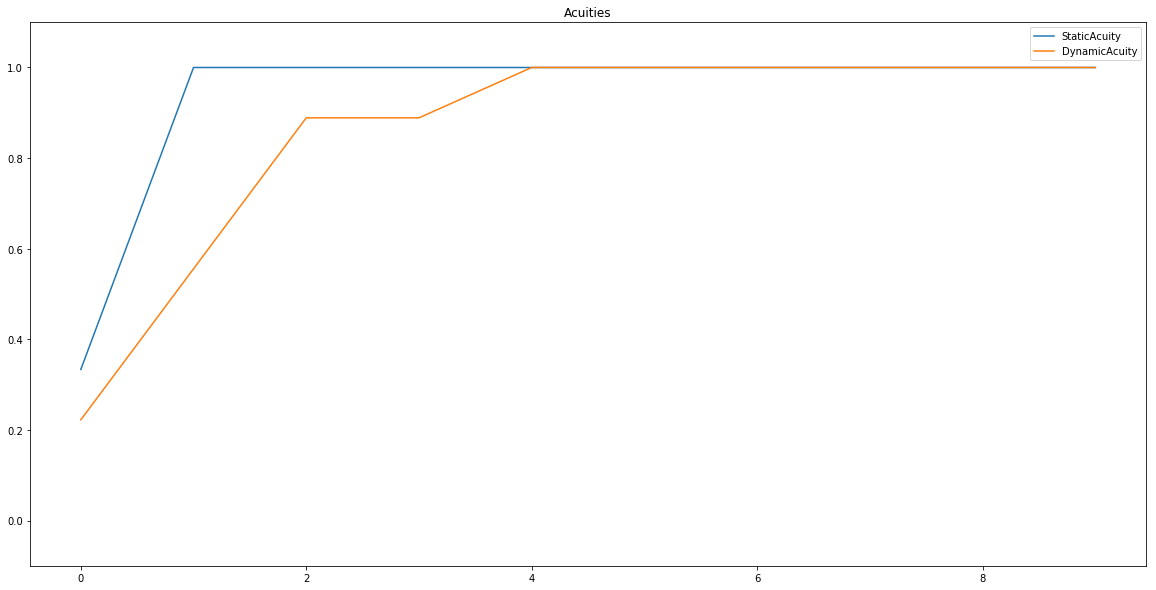

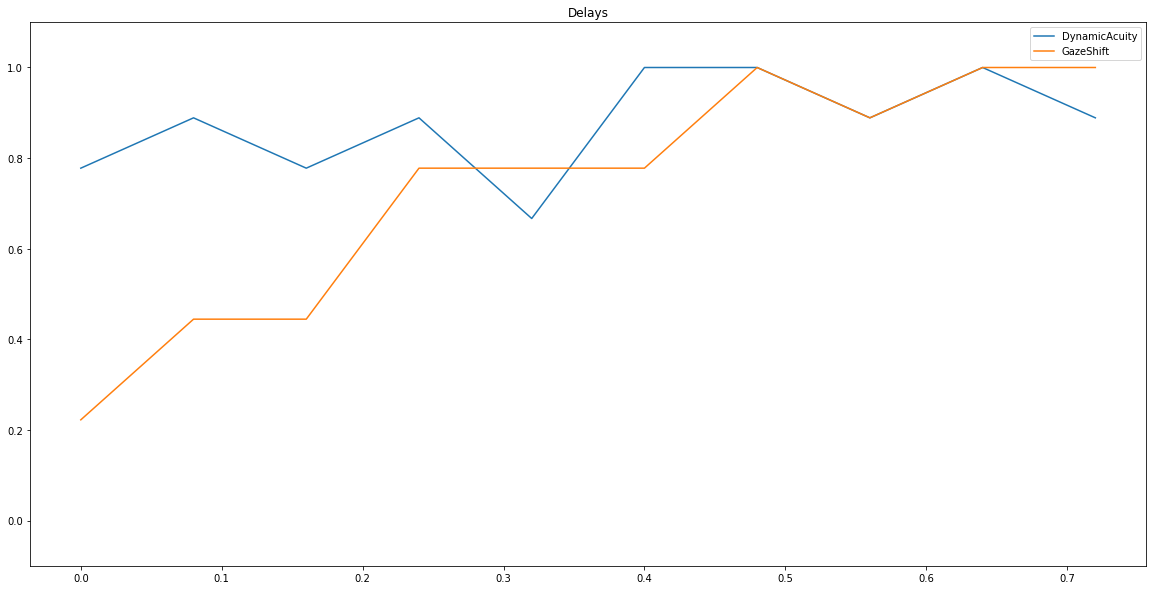

Left {0.0: [4, 5], 0.08: [3, 4], 0.16: [3, 5], 0.24: [4, 5], 0.32: [3, 5], 0.4: [4, 4], 0.48: [5, 5], 0.56: [4, 4], 0.64: [3, 3], 0.72: [4, 5]}
Right {0.0: [3, 4], 0.08: [5, 5], 0.16: [4, 4], 0.24: [4, 4], 0.32: [3, 4], 0.4: [5, 5], 0.48: [4, 4], 0.56: [4, 5], 0.64: [6, 6], 0.72: [4, 4]}


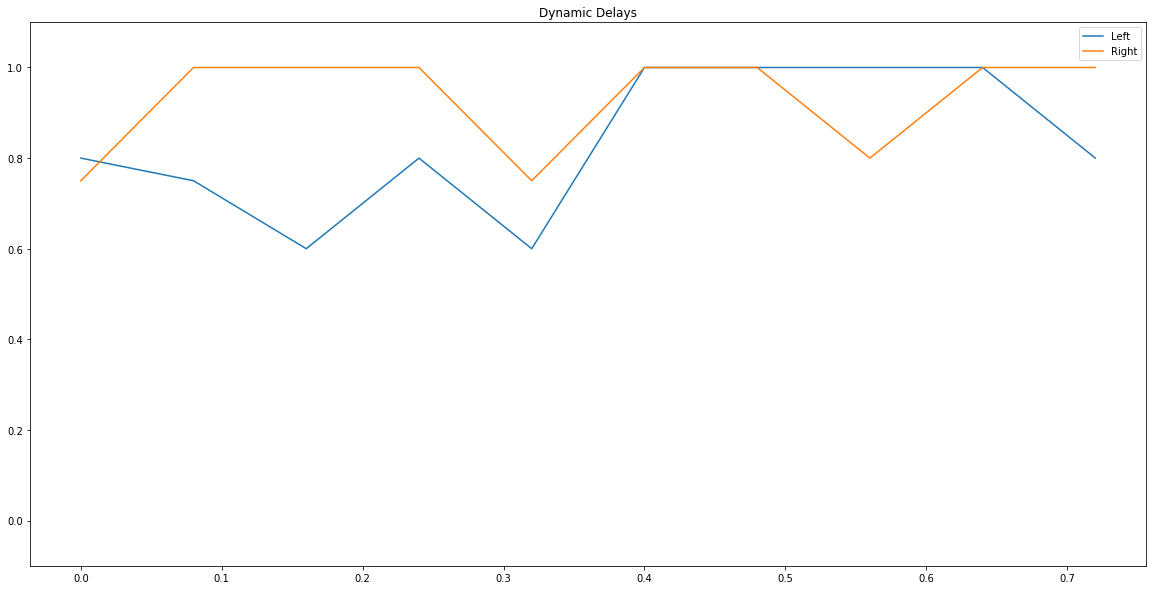

Left {0.0: [2, 4], 0.08: [3, 5], 0.16: [1, 4], 0.24: [4, 5], 0.32: [3, 4], 0.4: [4, 5], 0.48: [4, 4], 0.56: [4, 5], 0.64: [4, 4], 0.72: [5, 5]}
Right {0.0: [0, 5], 0.08: [1, 4], 0.16: [3, 5], 0.24: [3, 4], 0.32: [4, 5], 0.4: [3, 4], 0.48: [5, 5], 0.56: [4, 4], 0.64: [5, 5], 0.72: [4, 4]}


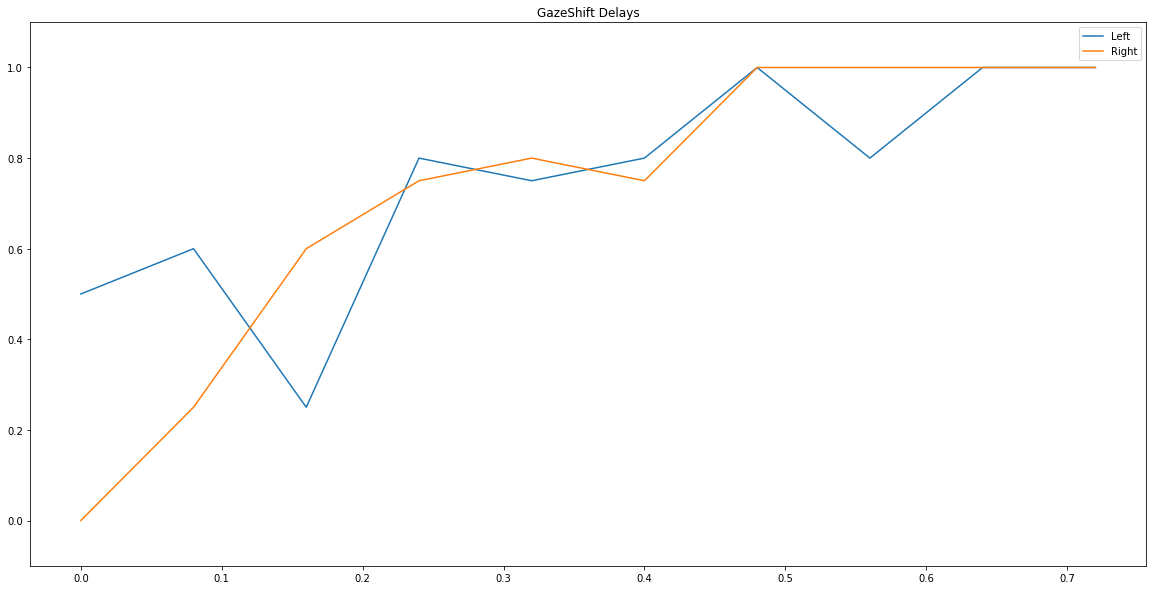

DynamicMeanPlot


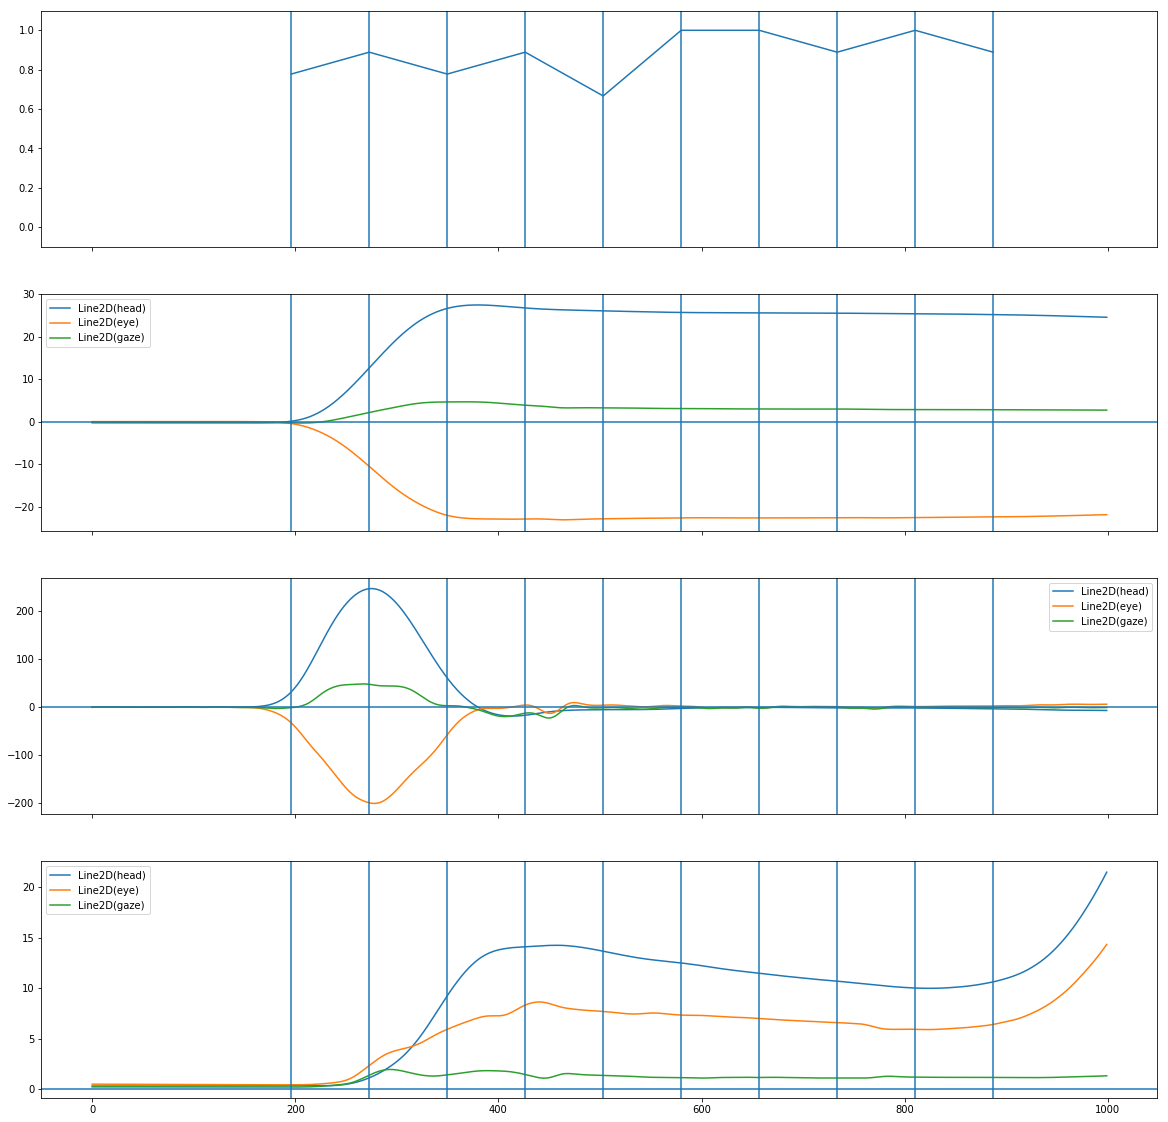

LeftDynamicMeanPlot


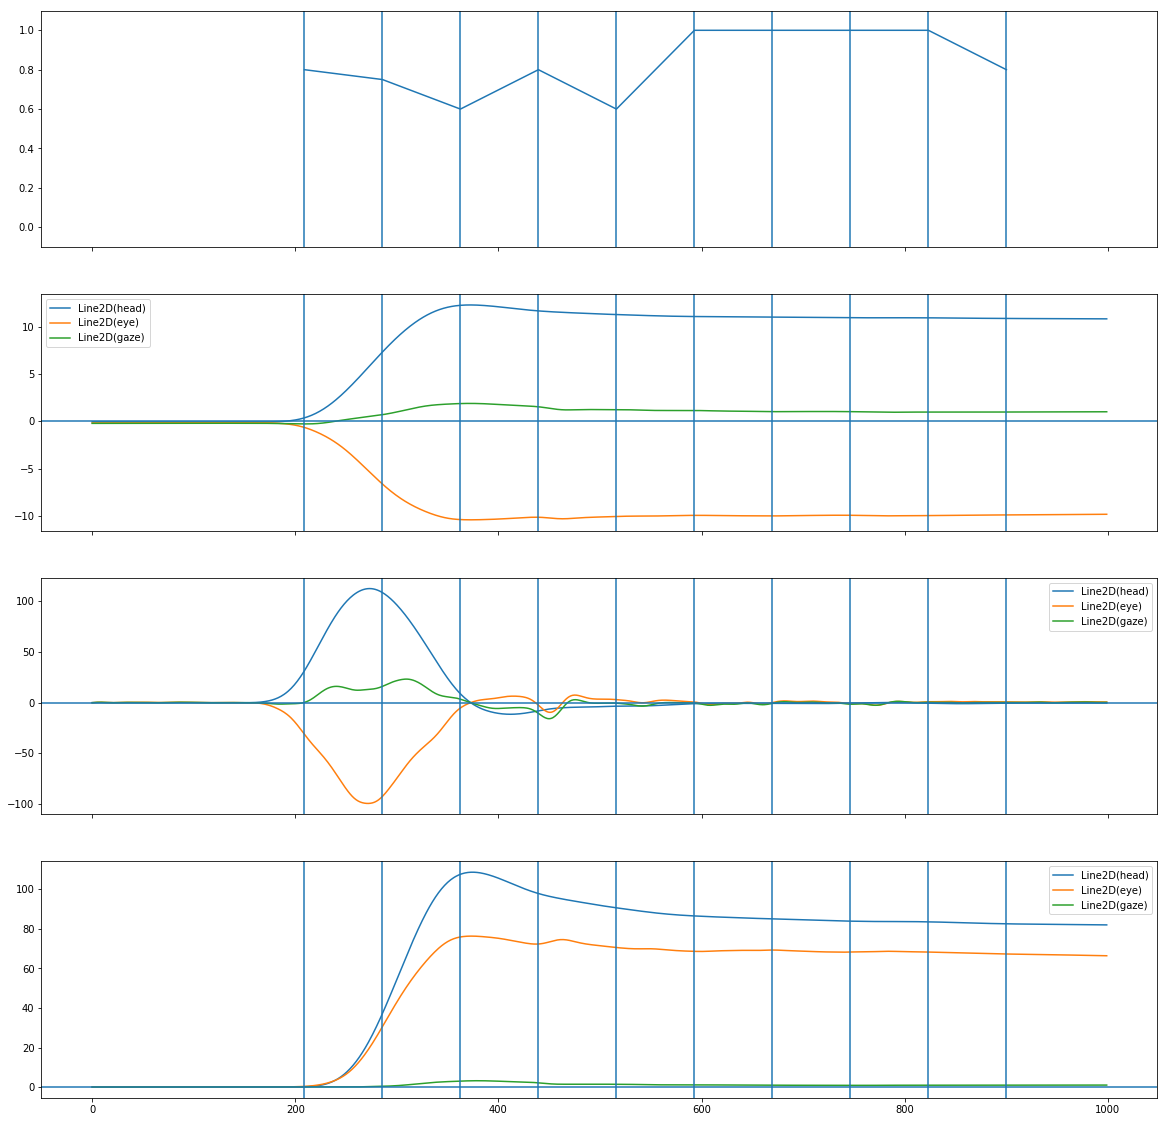

RightDynamicMeanPlot


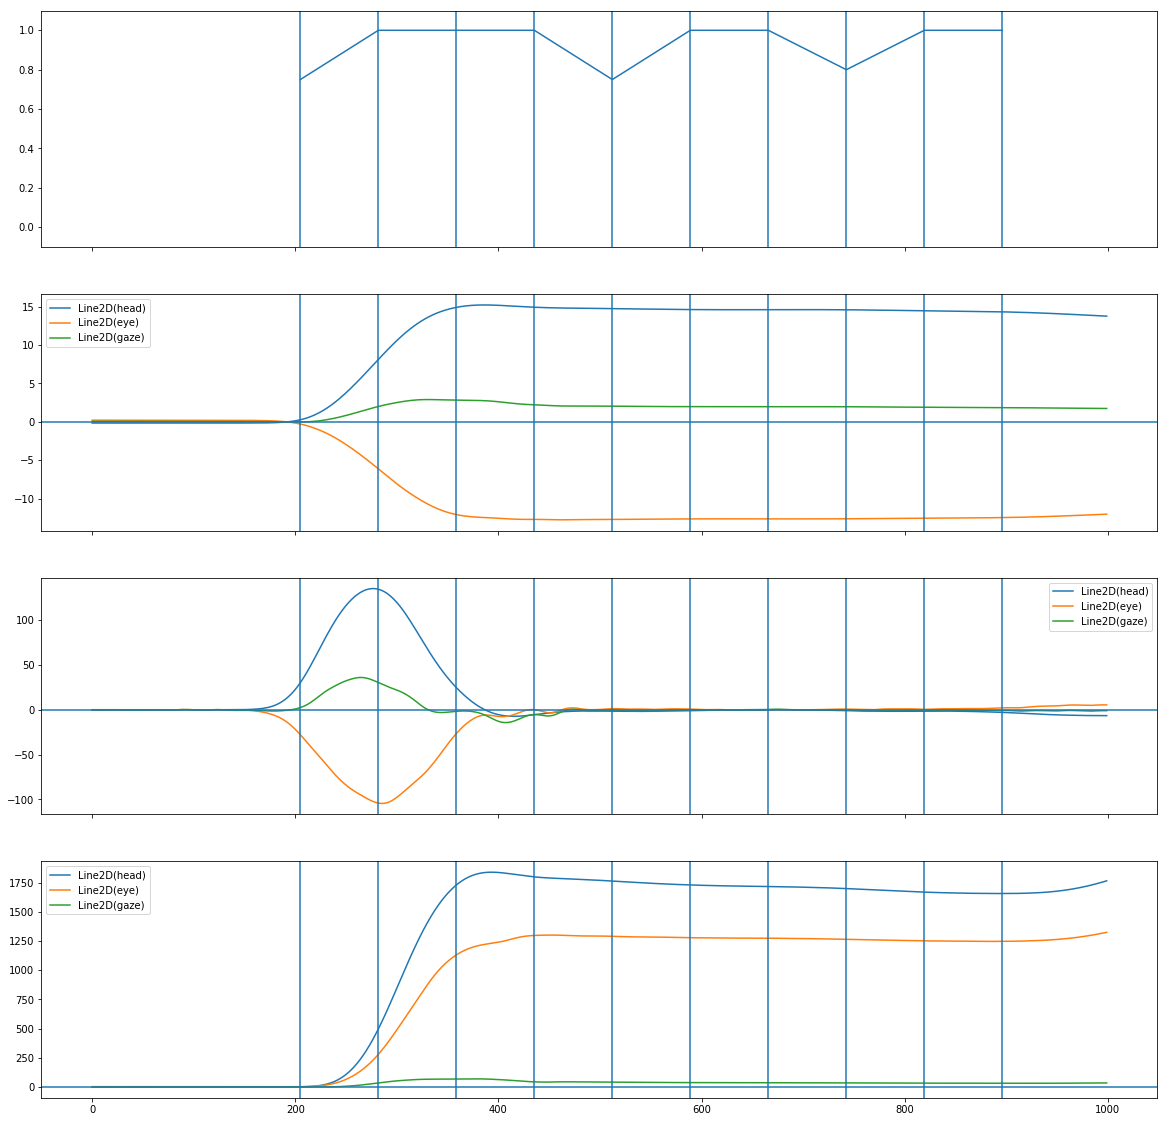

GazeShiftMeanPlot


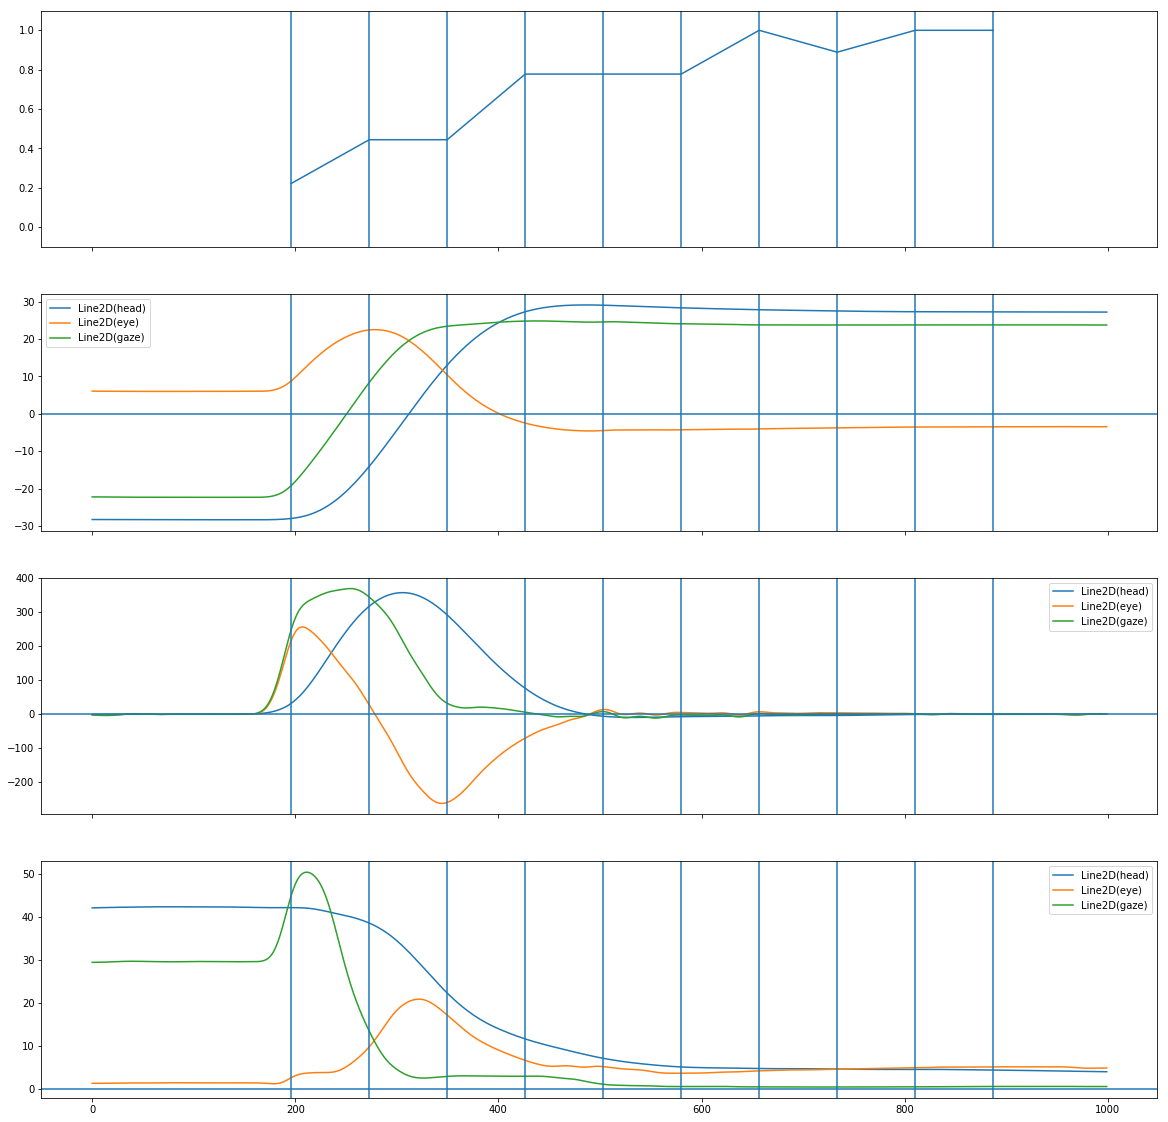

LeftGazeShiftMeanPlot


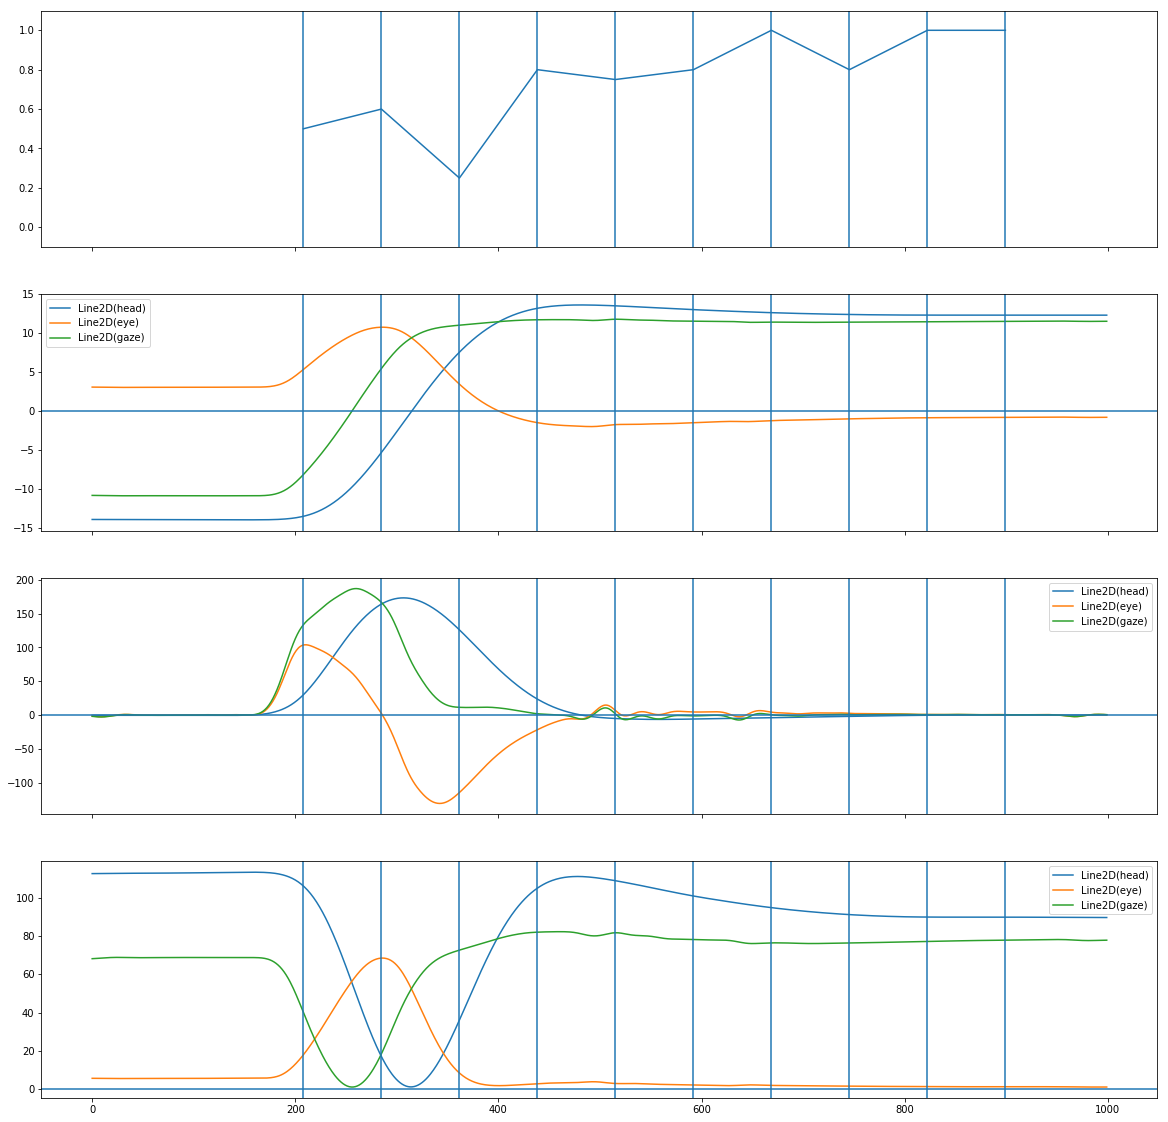

RightGazeShiftMeanPlot


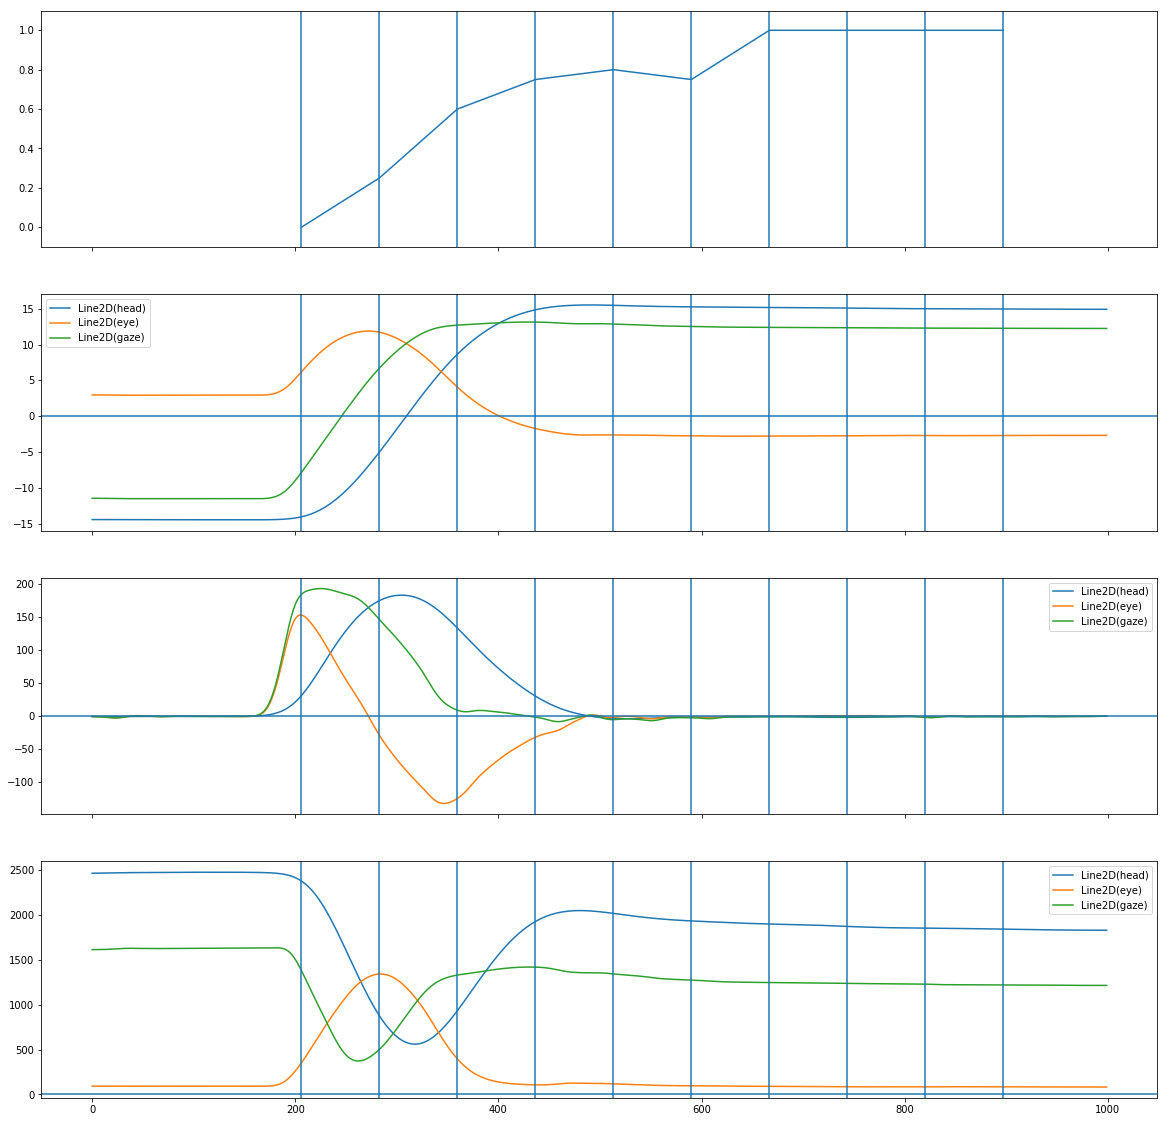

LeftDynamicAcuity


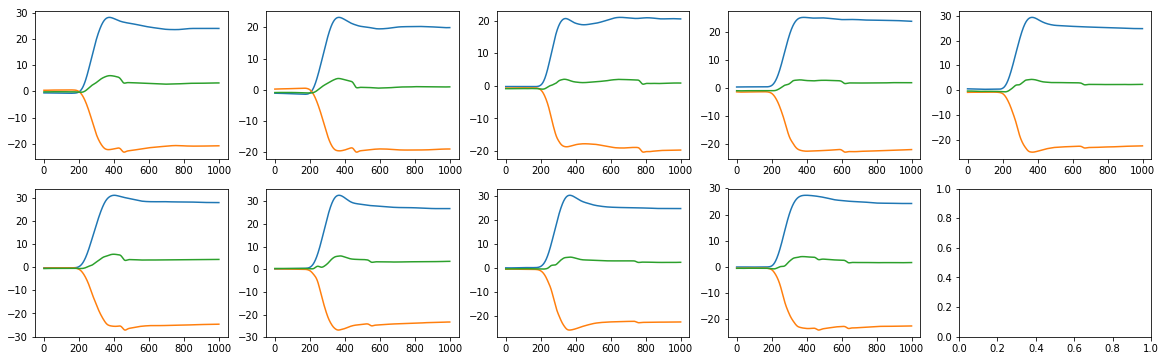

RightDynamicAcuity


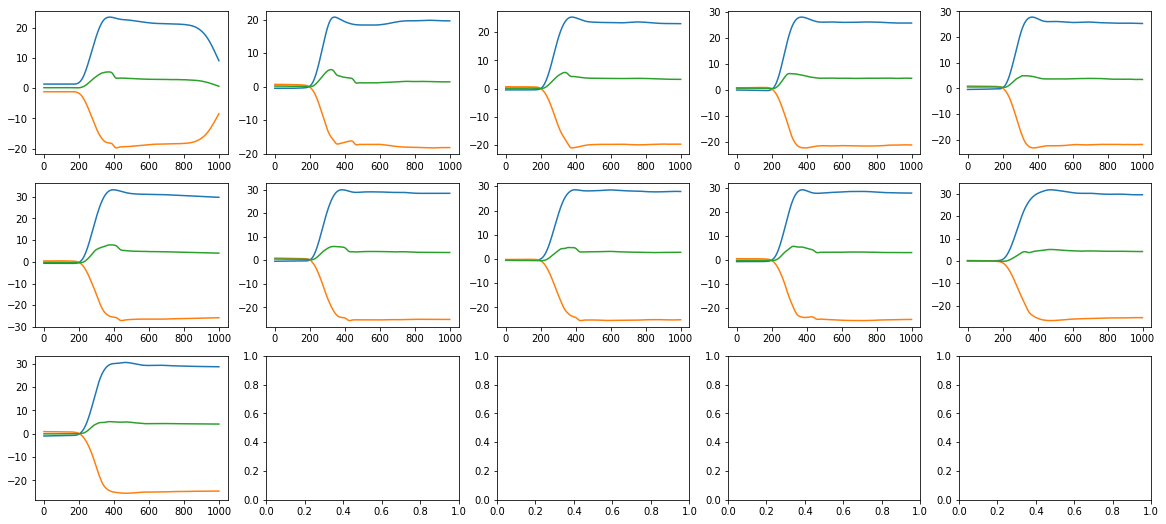

LeftGazeShift


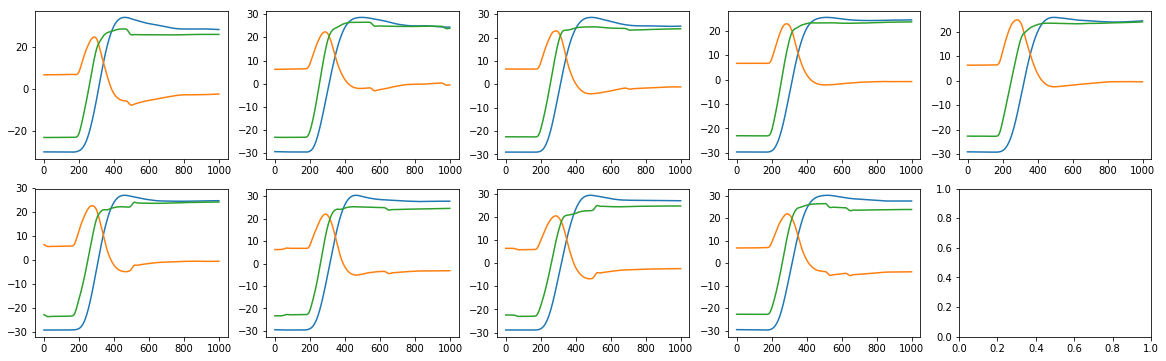

RightGazeShift


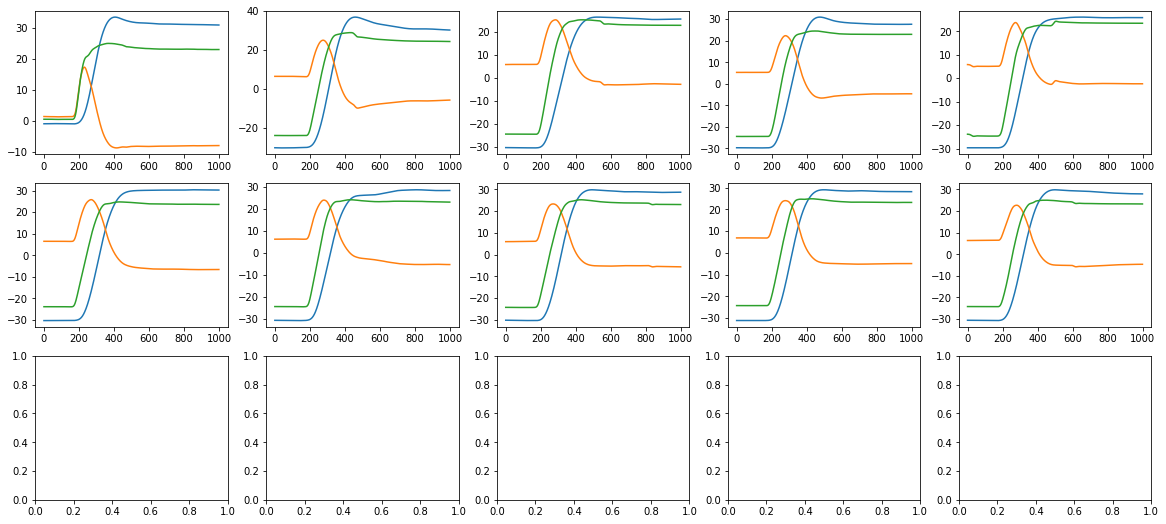

In [27]:
S_index += 1
sub_para = ["AcuityLog_2019_08_19_10_20_29.txt",\
        "AcuityLog_2019_08_19_10_35_08.txt",\
        "JumpLog__2019_08_19_10_20_29.txt",\
        "JumpLog__2019_08_19_10_35_08.txt",\
        "JumpLog__2019_08_19_10_35_08_2.txt",\
        "AcuityLog_2019_08_19_10_50_10.txt",\
        "",\
        "Mdata.mat",\
        "0",\
        "MdataH.mat"]
DY_DL = []
GA_DL = [17]
run_subject(sub_para, DY_DL = DY_DL, GA_DL = GA_DL, plot_detail = False)

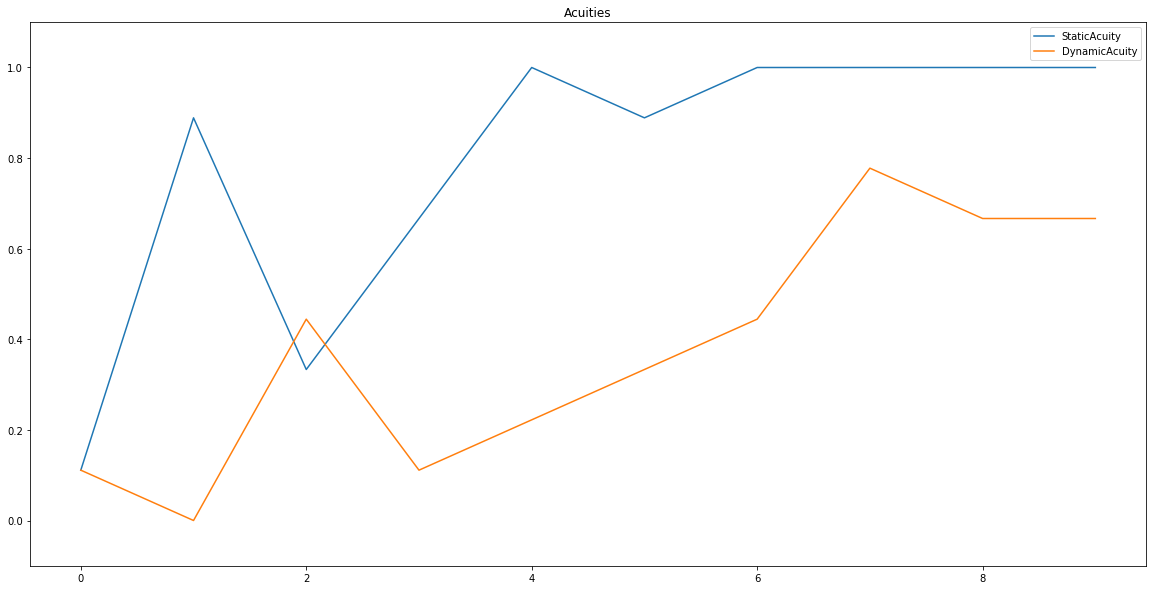

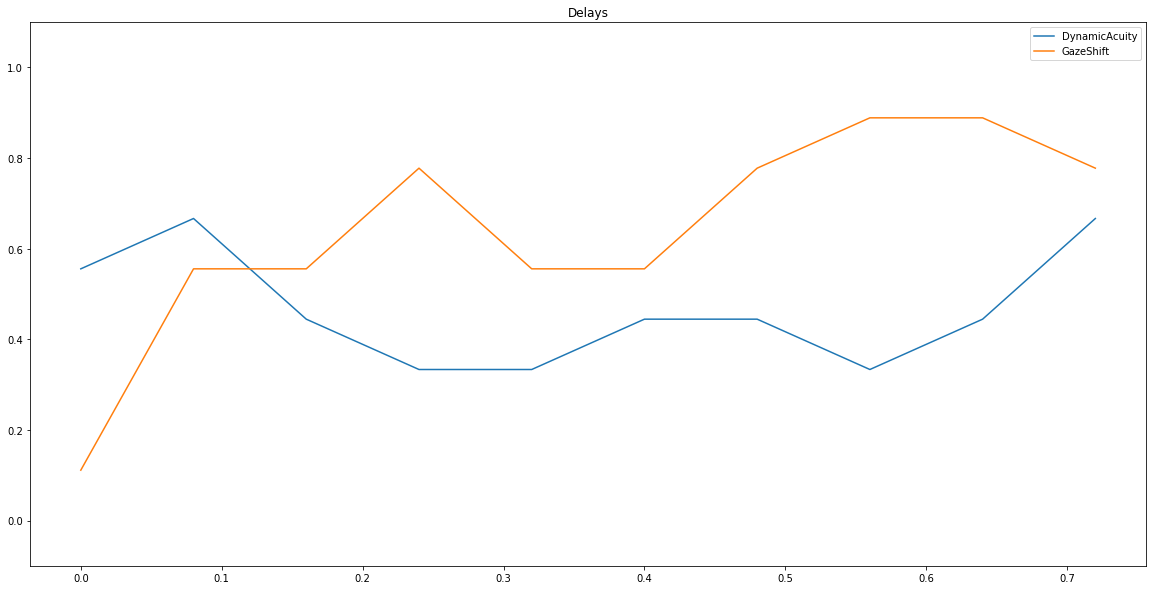

Left {0.0: [3, 3], 0.08: [2, 4], 0.16: [3, 5], 0.24: [2, 4], 0.32: [1, 4], 0.4: [3, 4], 0.48: [2, 5], 0.56: [1, 4], 0.64: [4, 5], 0.72: [2, 4]}
Right {0.0: [2, 6], 0.08: [4, 5], 0.16: [1, 4], 0.24: [1, 5], 0.32: [2, 5], 0.4: [1, 5], 0.48: [2, 4], 0.56: [2, 5], 0.64: [0, 4], 0.72: [4, 5]}


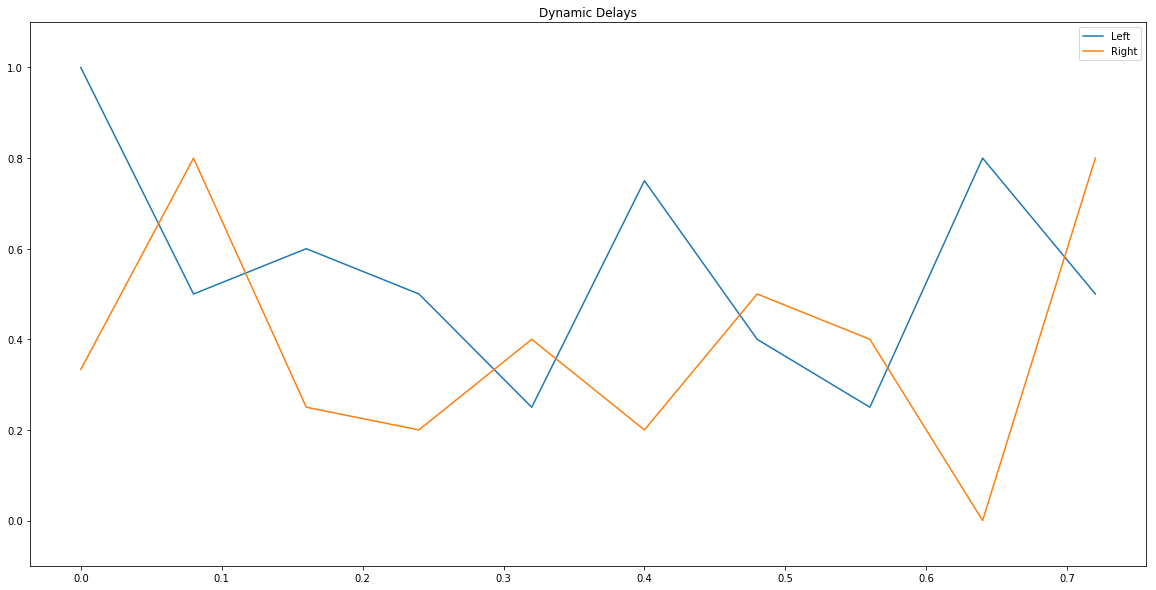

Left {0.0: [0, 4], 0.08: [3, 6], 0.16: [2, 4], 0.24: [4, 5], 0.32: [2, 4], 0.4: [3, 6], 0.48: [3, 4], 0.56: [4, 5], 0.64: [3, 4], 0.72: [4, 5]}
Right {0.0: [1, 5], 0.08: [2, 3], 0.16: [3, 5], 0.24: [3, 4], 0.32: [3, 5], 0.4: [2, 3], 0.48: [4, 5], 0.56: [4, 4], 0.64: [5, 5], 0.72: [3, 4]}


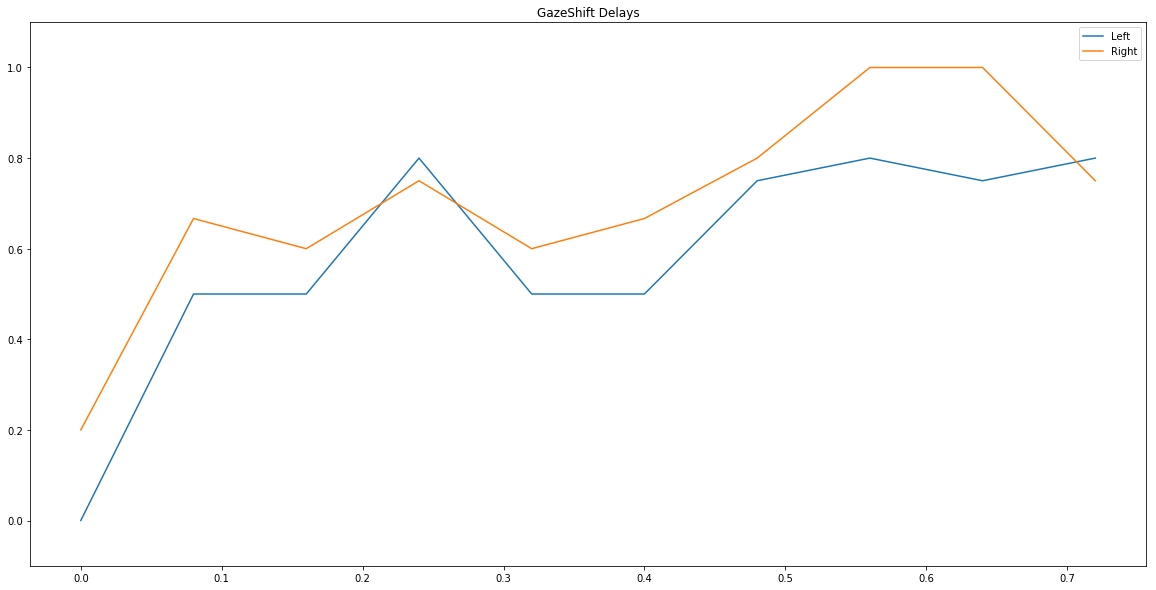

DynamicMeanPlot


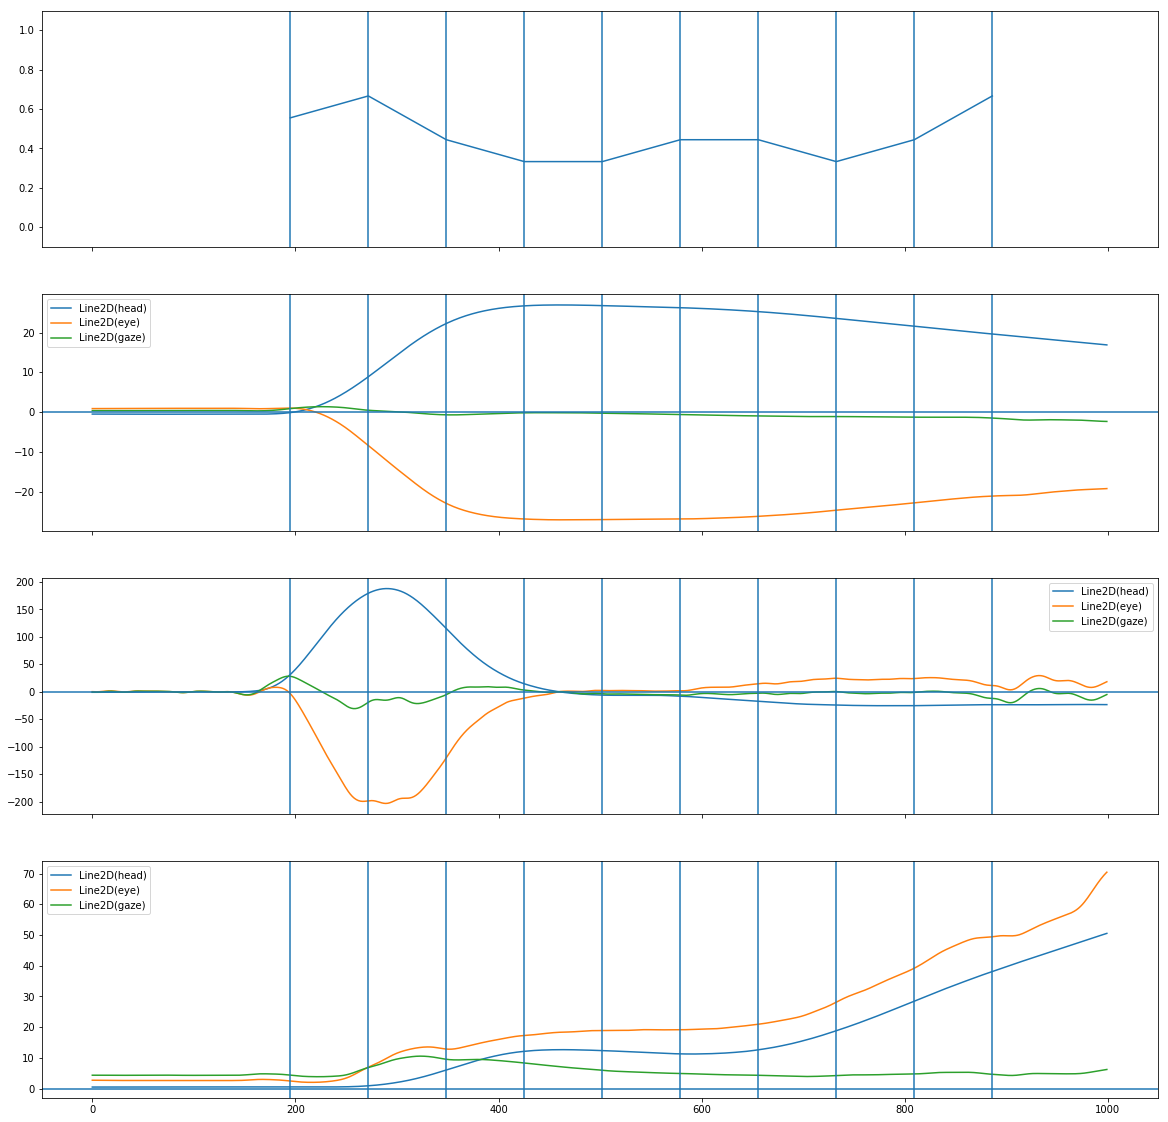

LeftDynamicMeanPlot


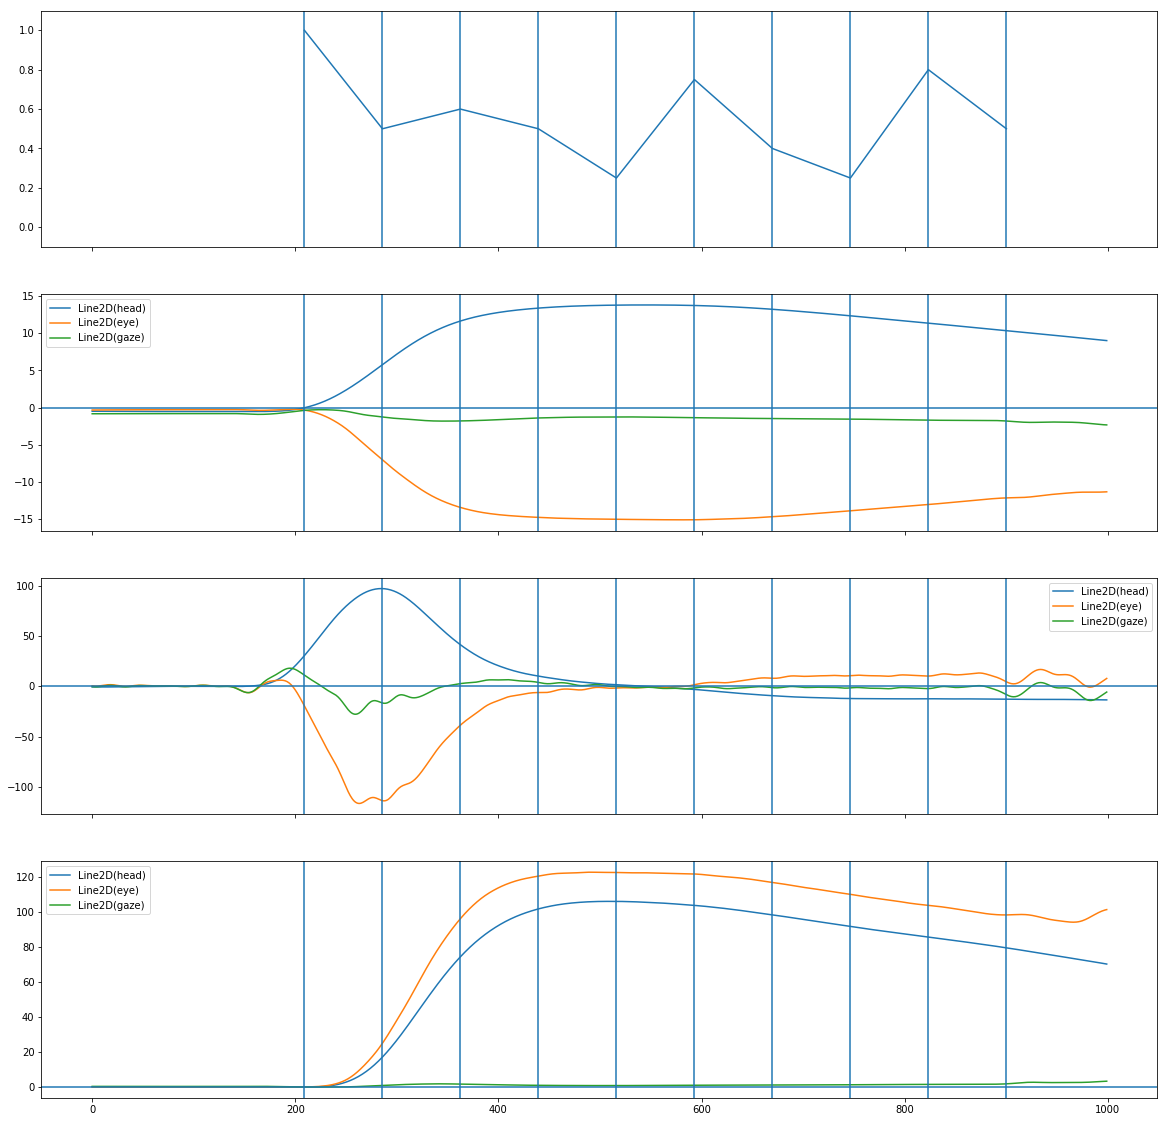

RightDynamicMeanPlot


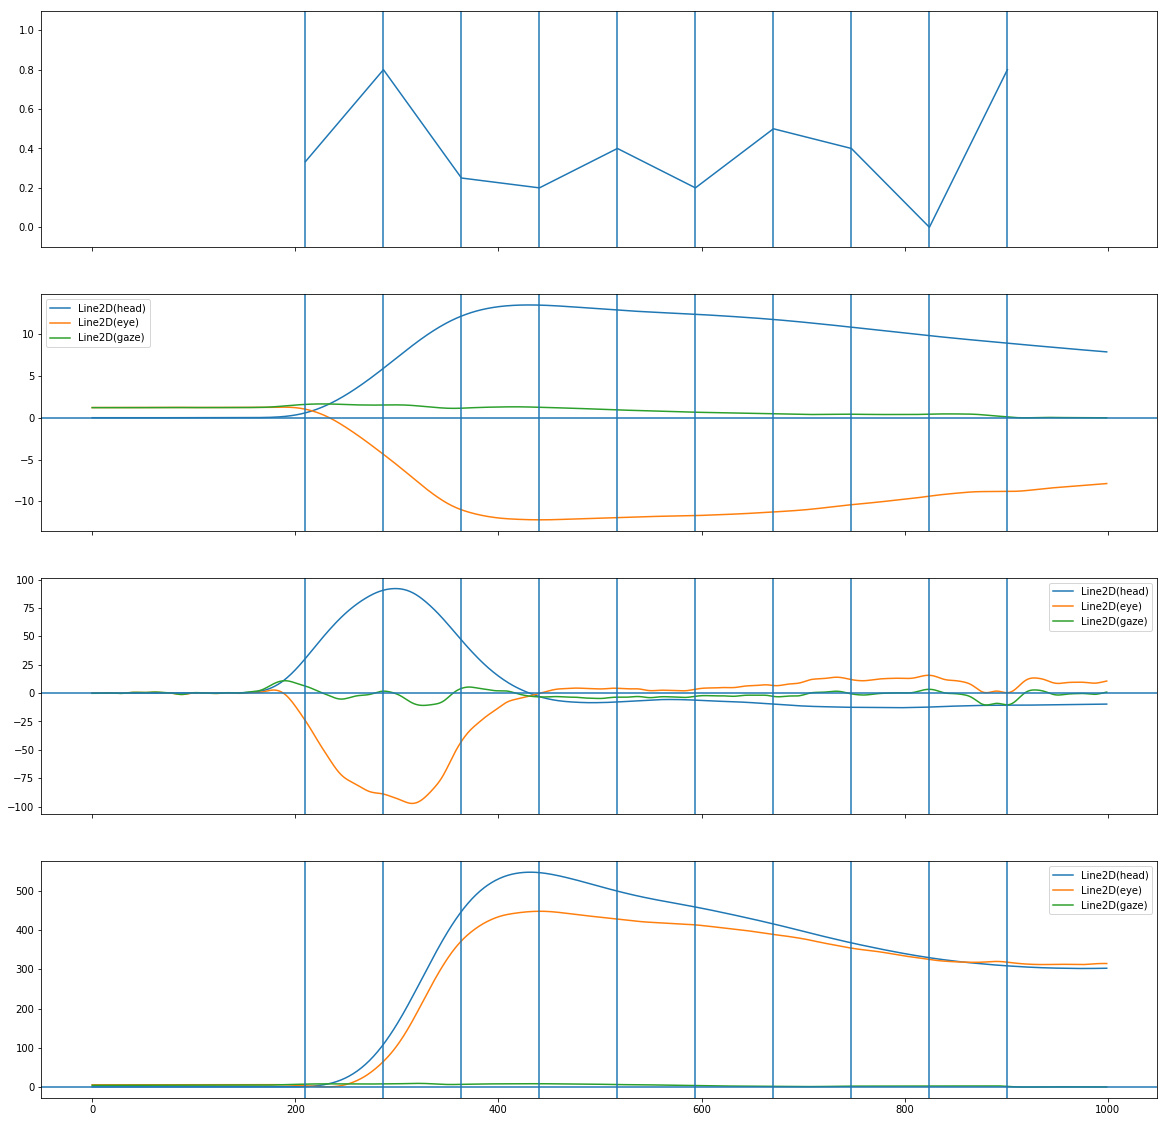

GazeShiftMeanPlot


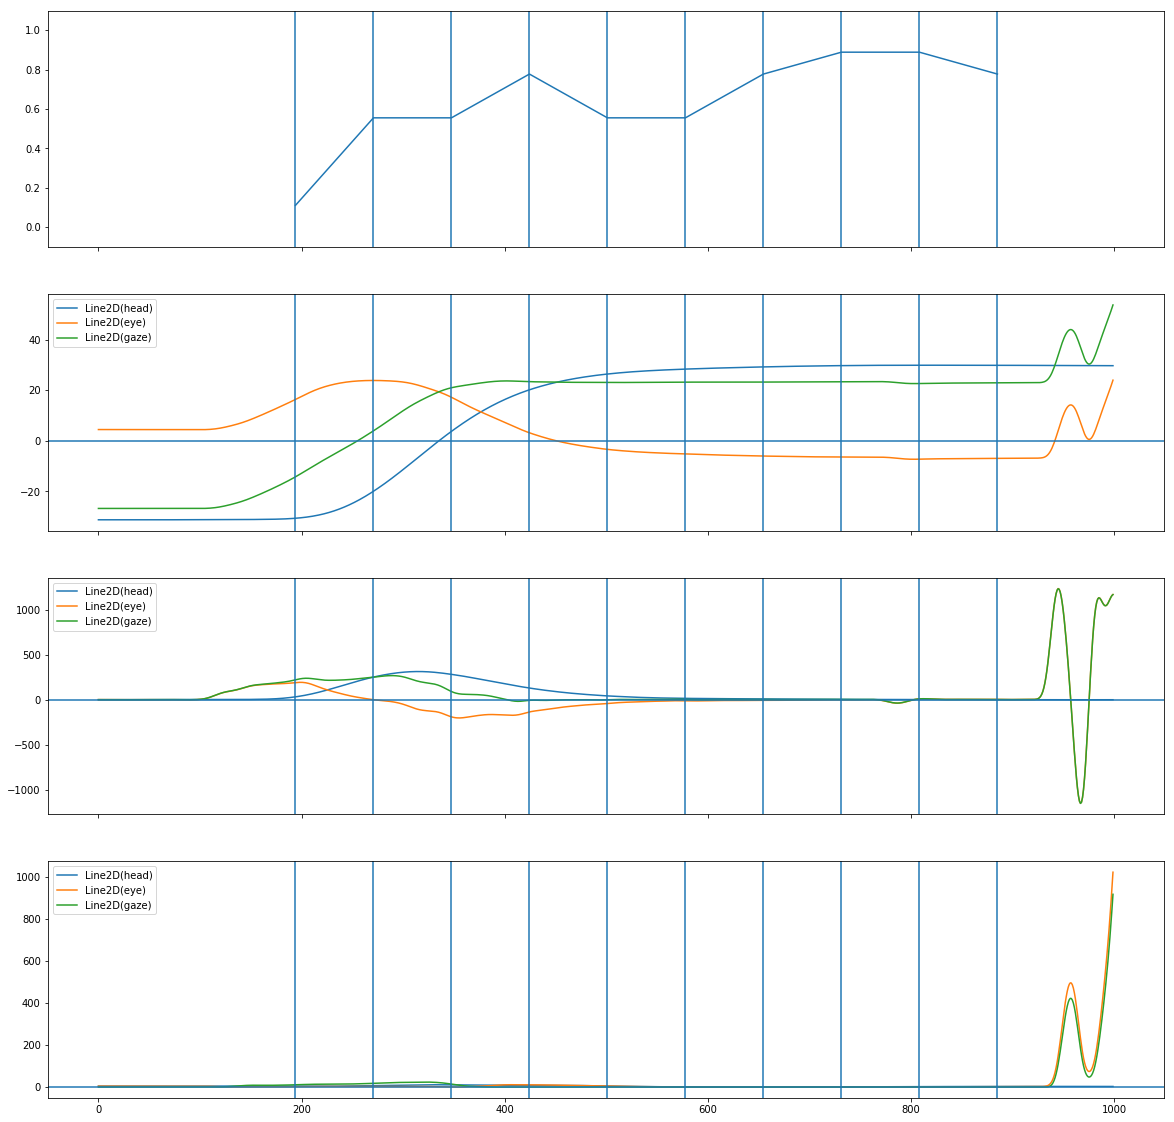

LeftGazeShiftMeanPlot


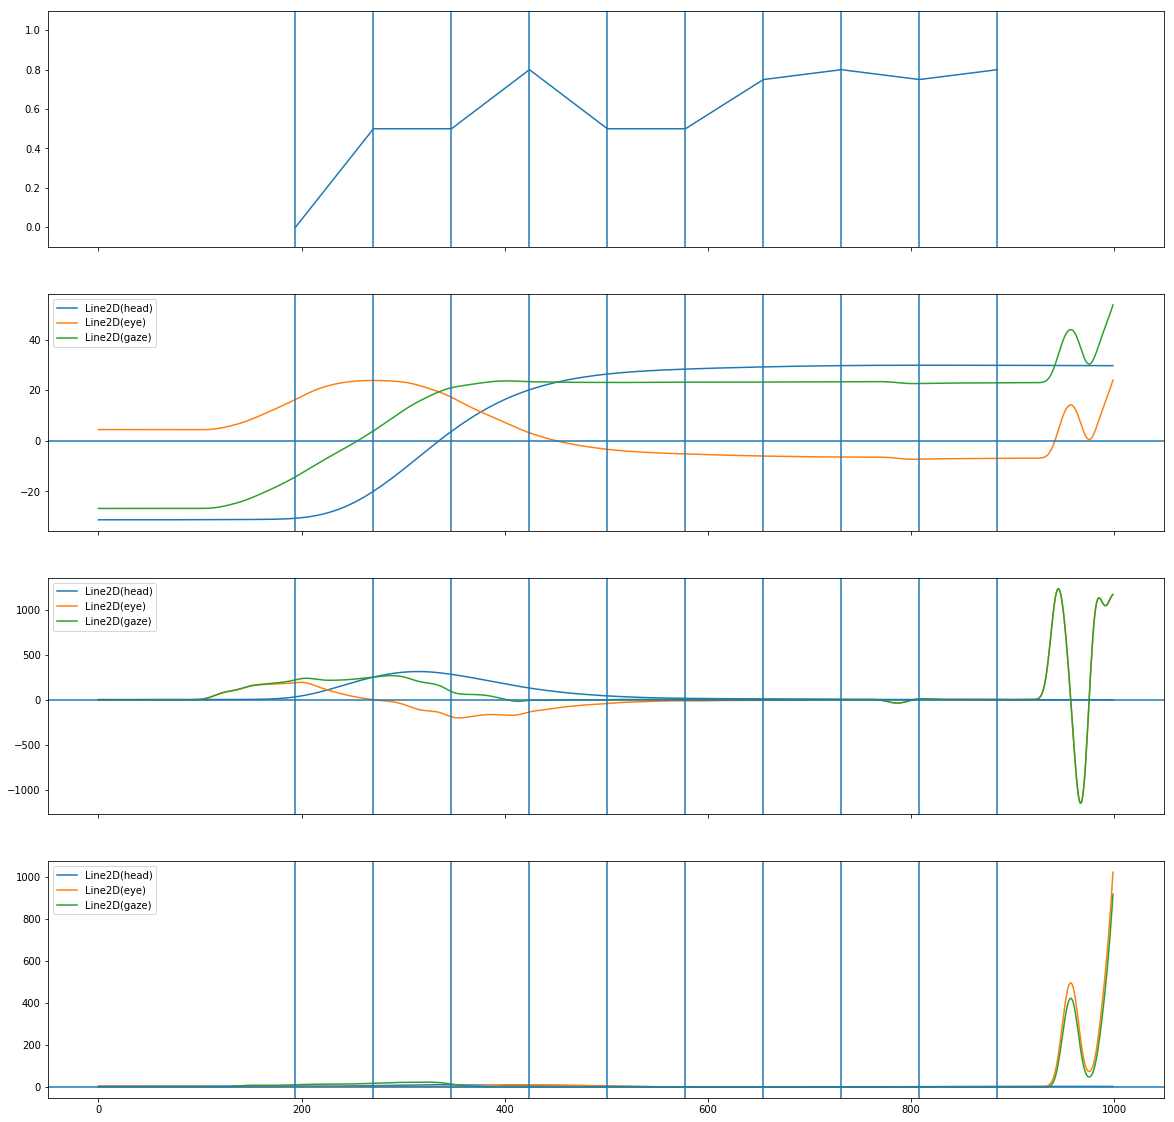

RightGazeShiftMeanPlot


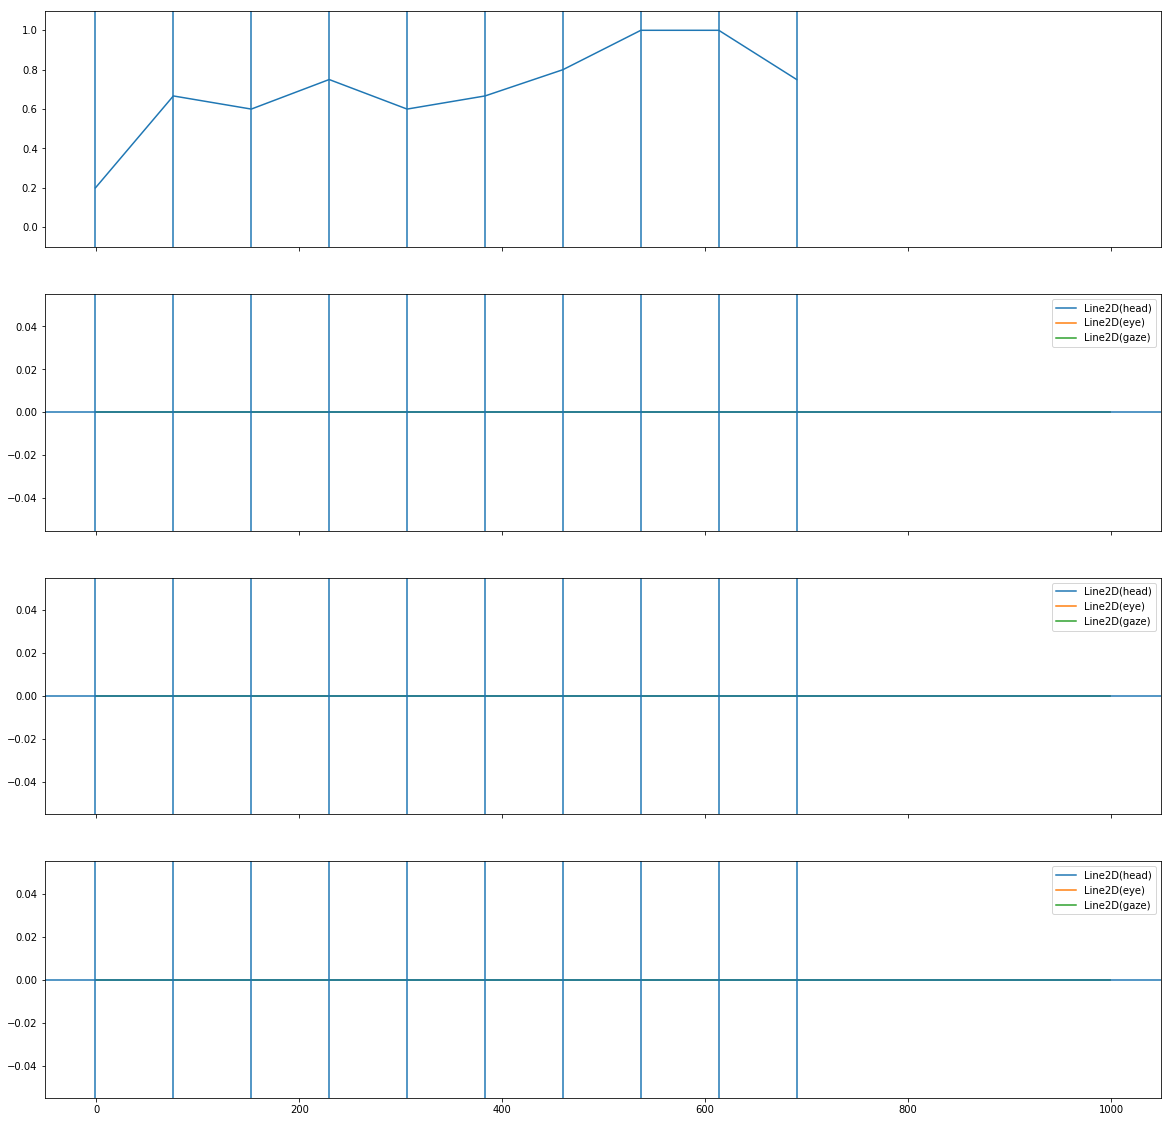

LeftDynamicAcuity


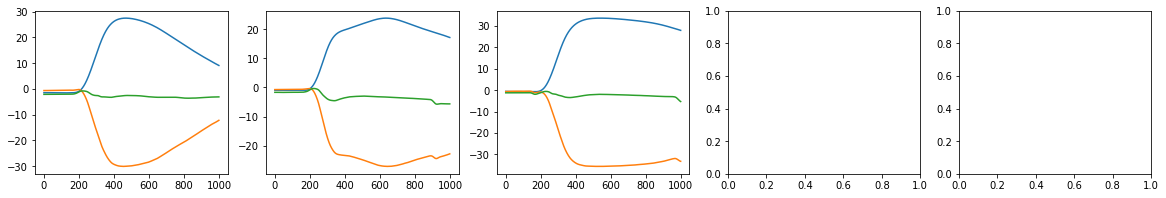

RightDynamicAcuity


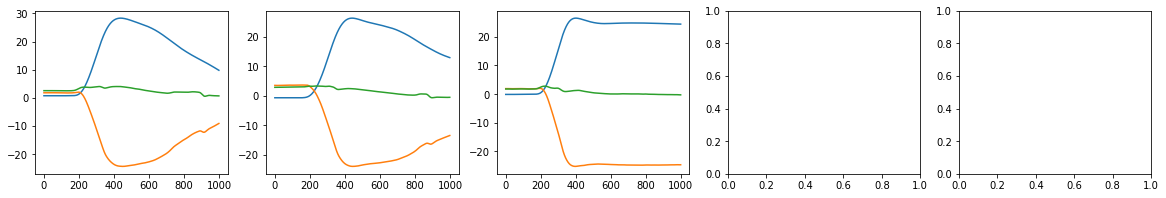

LeftGazeShift


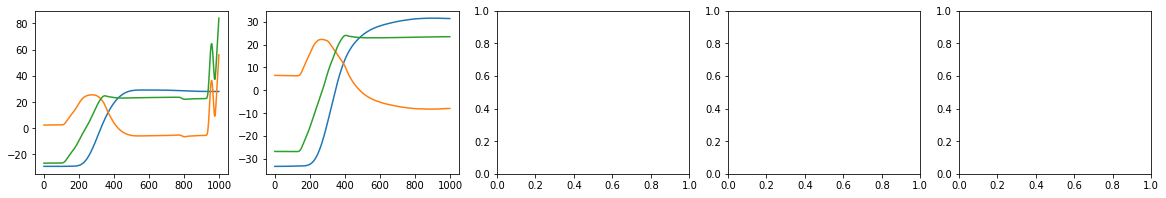

RightGazeShift


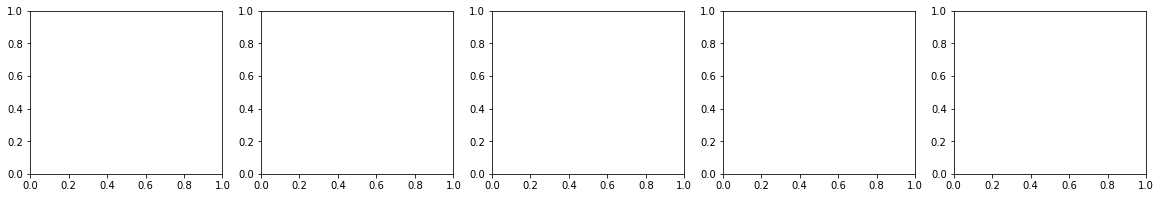

In [28]:
S_index += 1
sub_para = ["AcuityLog_2019_08_30_01_05_31.txt",\
        "AcuityLog_2019_08_30_01_19_07.txt",\
        "JumpLog__2019_08_30_01_05_31.txt",\
        "JumpLog__2019_08_30_01_19_07.txt",\
        "JumpLog__2019_08_30_01_19_07_2.txt",\
        "AcuityLog_2019_08_30_01_33_17.txt",\
        "",\
        "Qdata.mat",\
        "0",\
        "QdataH.mat"
       ]
DY_DL = [0,5,8,9,10,11,12,13,14,15,16,17,18,19]
GA_DL = [0,1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
run_subject(sub_para,DY_DL = DY_DL, GA_DL = GA_DL, plot_detail = False)

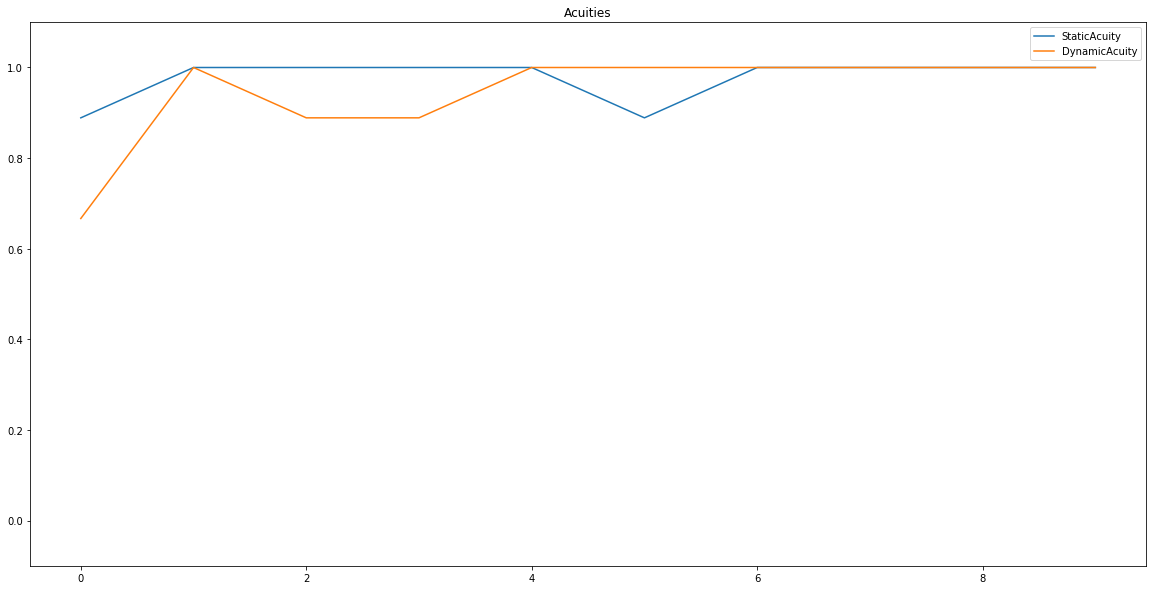

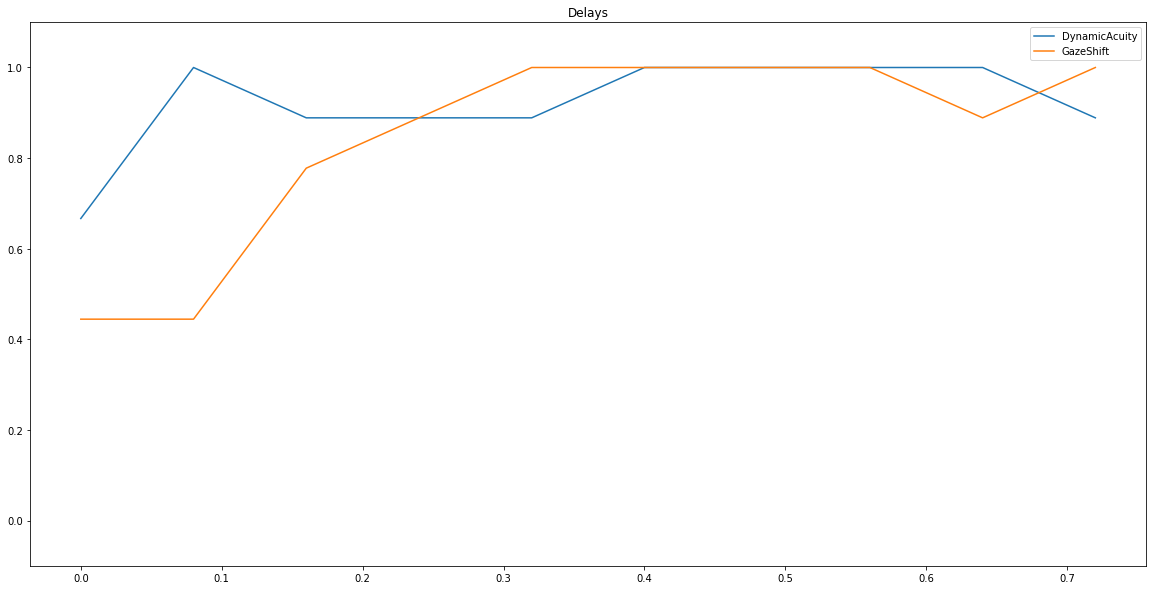

Left {0.0: [1, 4], 0.08: [5, 5], 0.16: [4, 4], 0.24: [5, 5], 0.32: [3, 4], 0.4: [5, 5], 0.48: [4, 4], 0.56: [5, 5], 0.64: [4, 4], 0.72: [4, 5]}
Right {0.0: [5, 5], 0.08: [4, 4], 0.16: [4, 5], 0.24: [3, 4], 0.32: [5, 5], 0.4: [4, 4], 0.48: [5, 5], 0.56: [4, 4], 0.64: [5, 5], 0.72: [4, 4]}


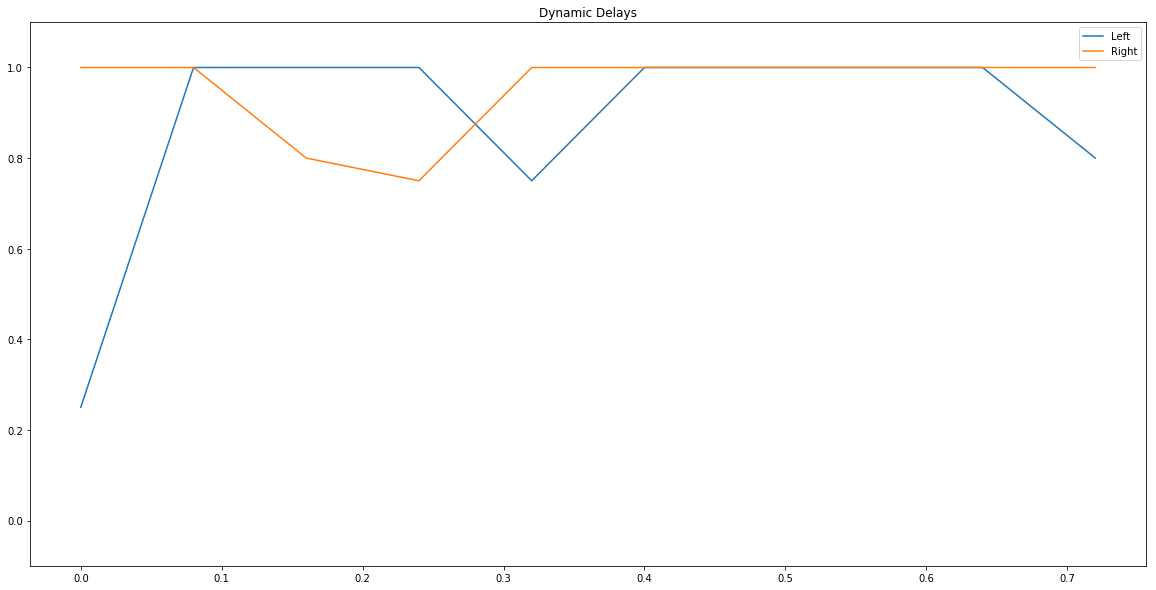

Left {0.0: [1, 4], 0.08: [2, 5], 0.16: [2, 4], 0.24: [4, 5], 0.32: [4, 4], 0.4: [5, 5], 0.48: [4, 4], 0.56: [5, 5], 0.64: [3, 4], 0.72: [5, 5]}
Right {0.0: [3, 5], 0.08: [2, 4], 0.16: [5, 5], 0.24: [4, 4], 0.32: [5, 5], 0.4: [4, 4], 0.48: [5, 5], 0.56: [4, 4], 0.64: [5, 5], 0.72: [4, 4]}


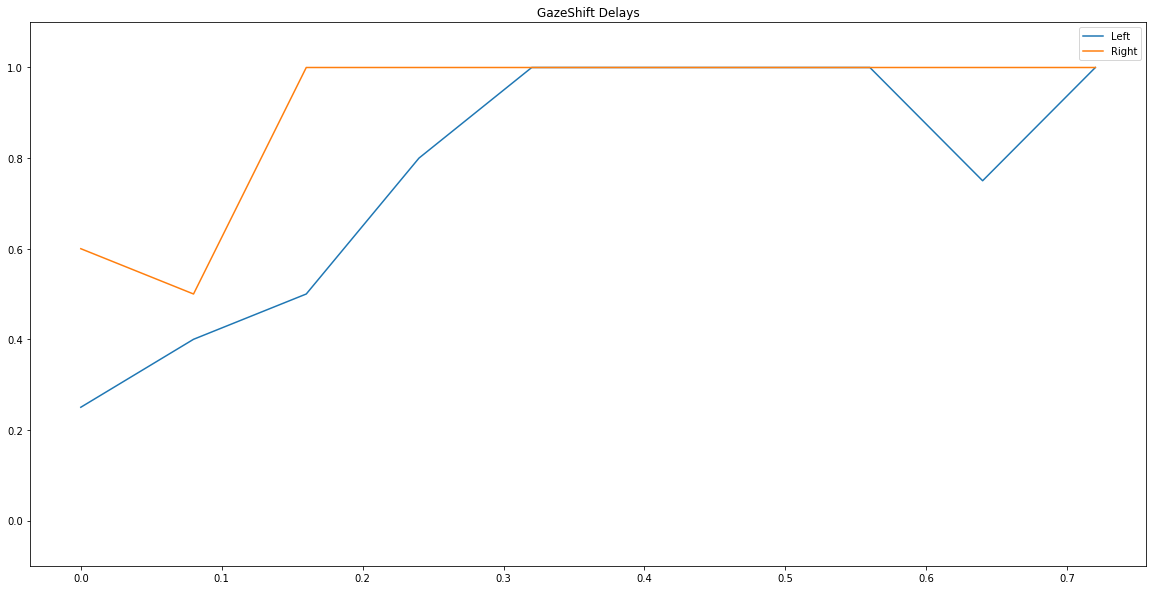

DynamicMeanPlot


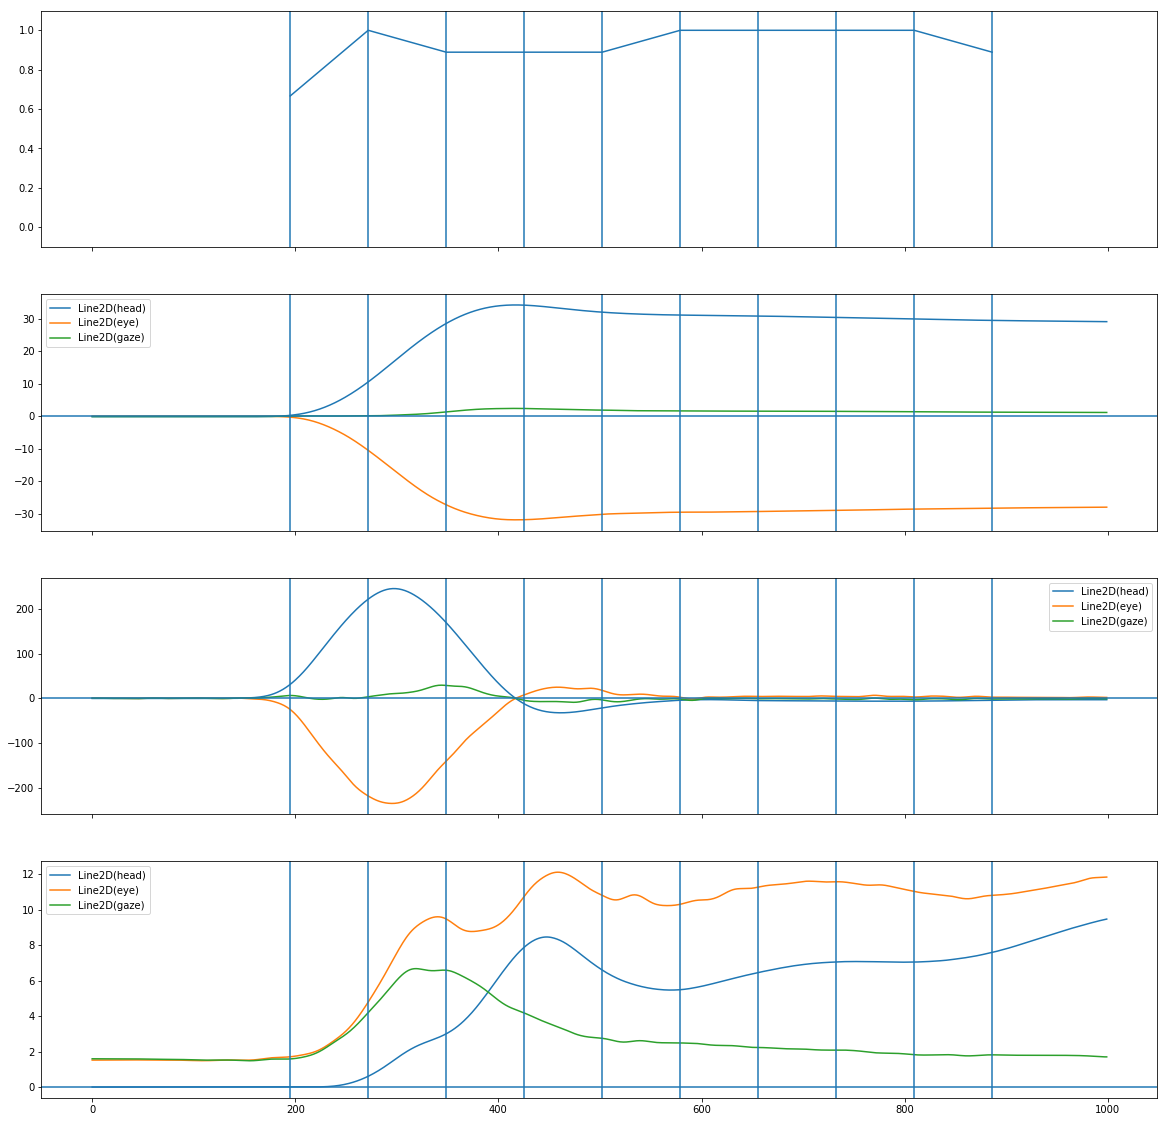

LeftDynamicMeanPlot


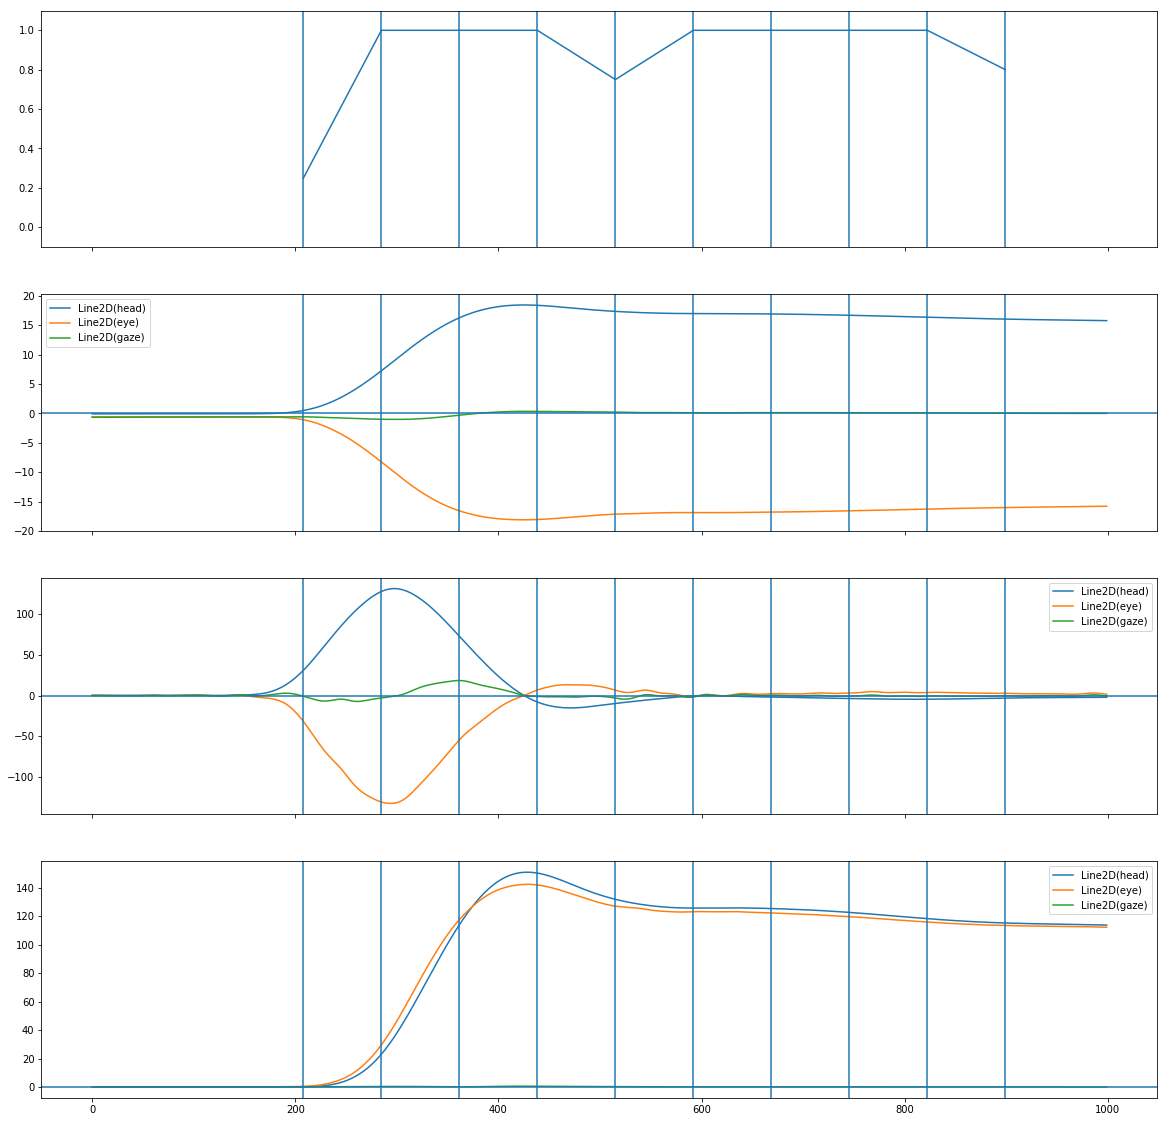

RightDynamicMeanPlot


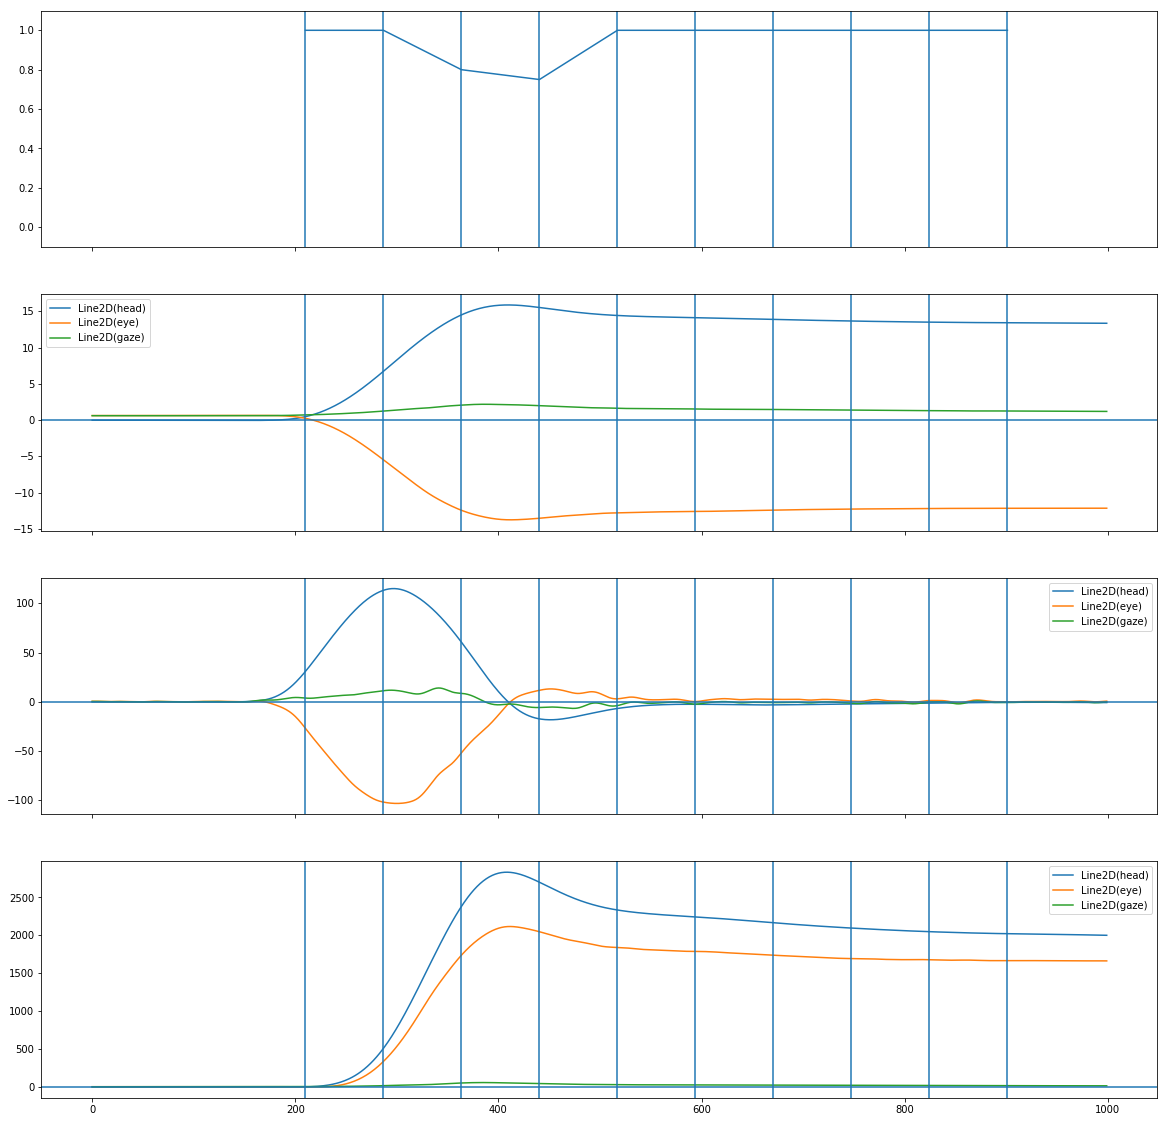

GazeShiftMeanPlot


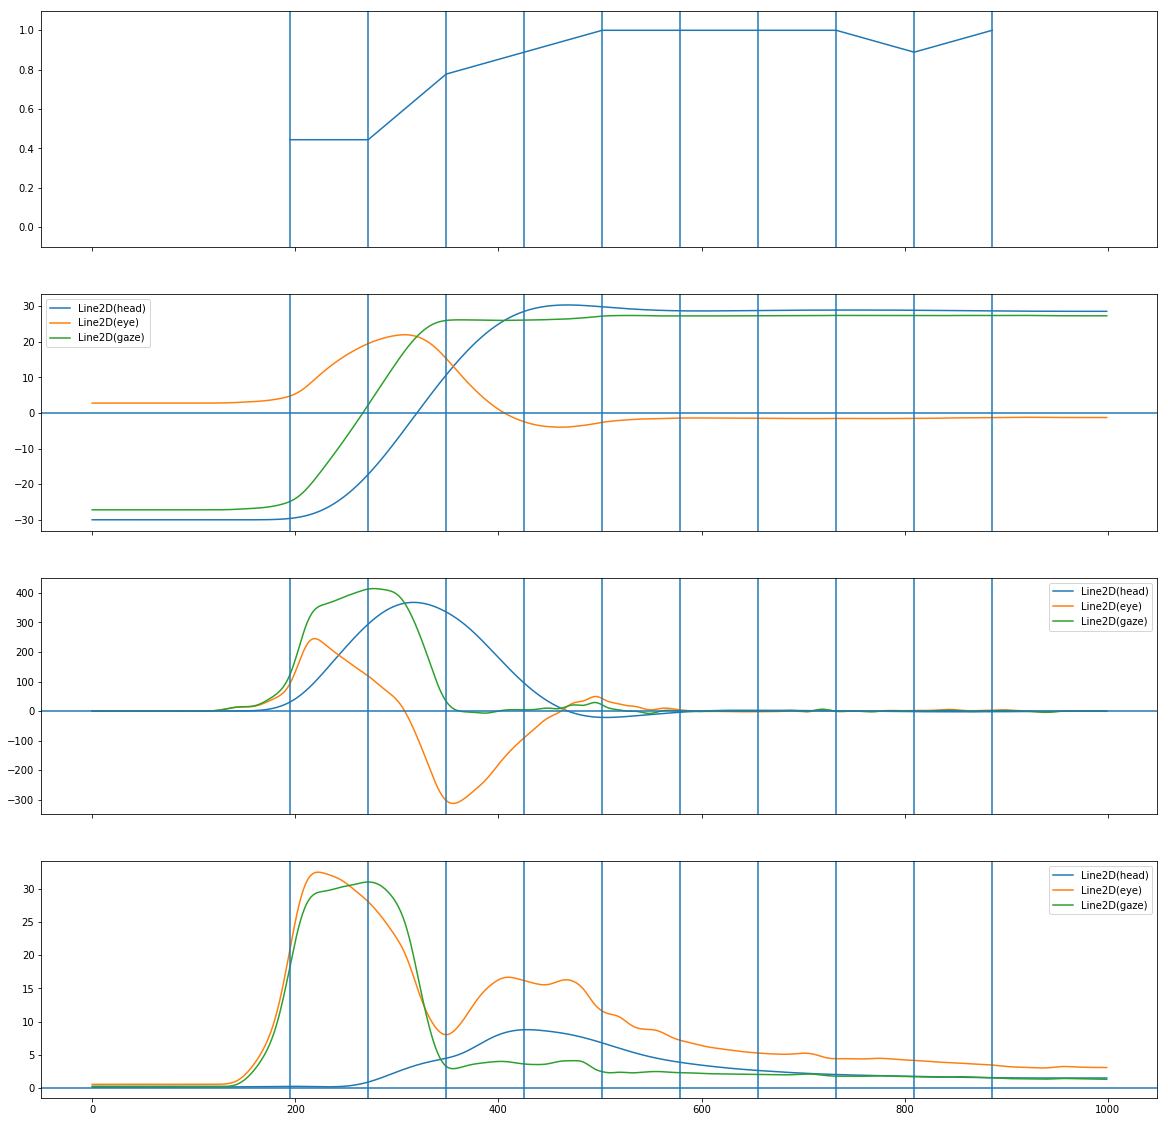

LeftGazeShiftMeanPlot


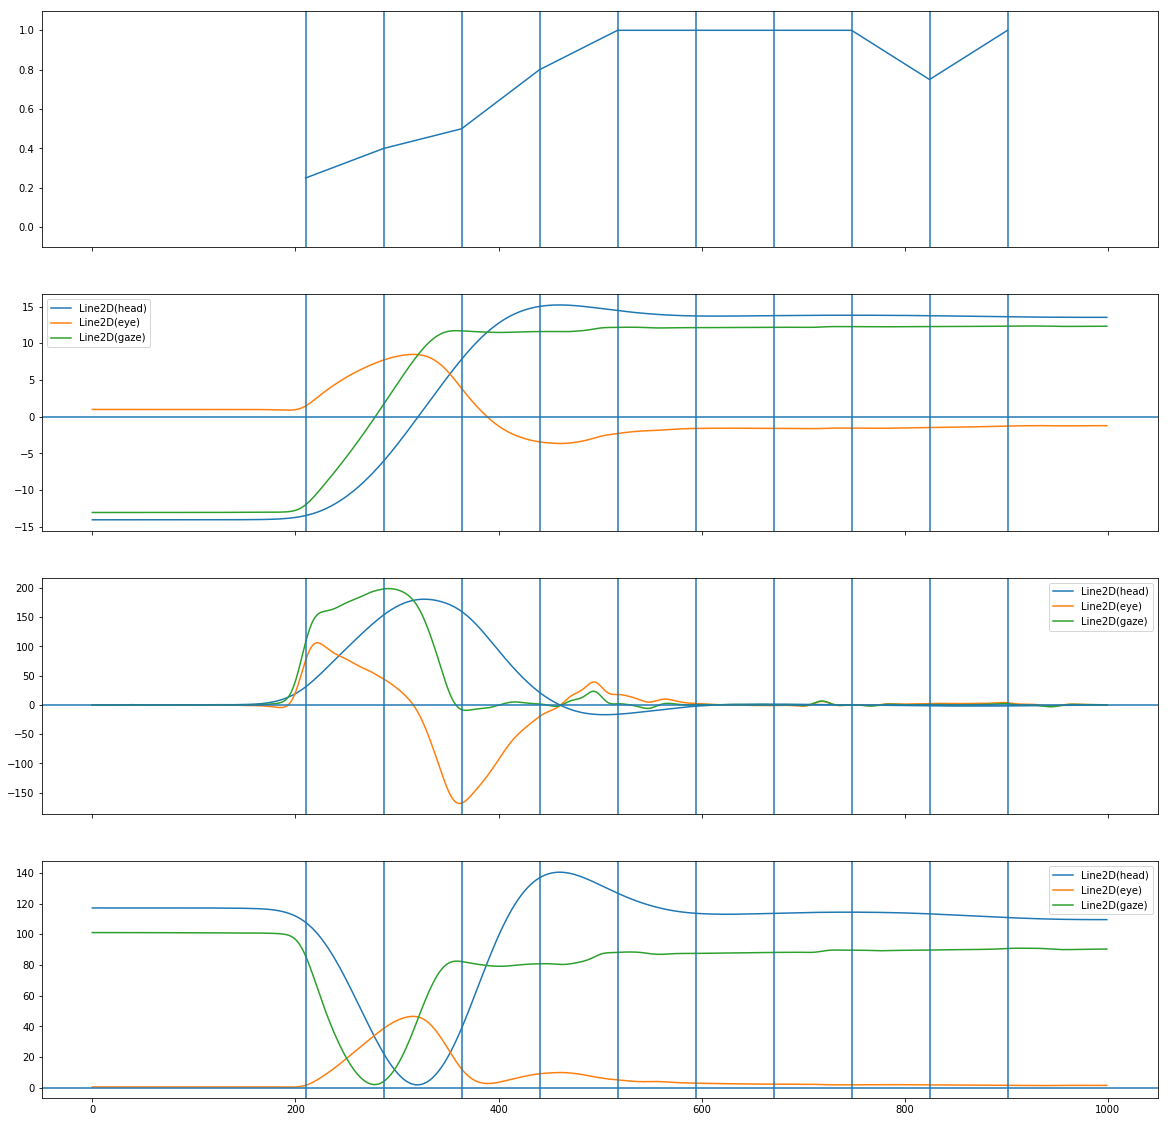

RightGazeShiftMeanPlot


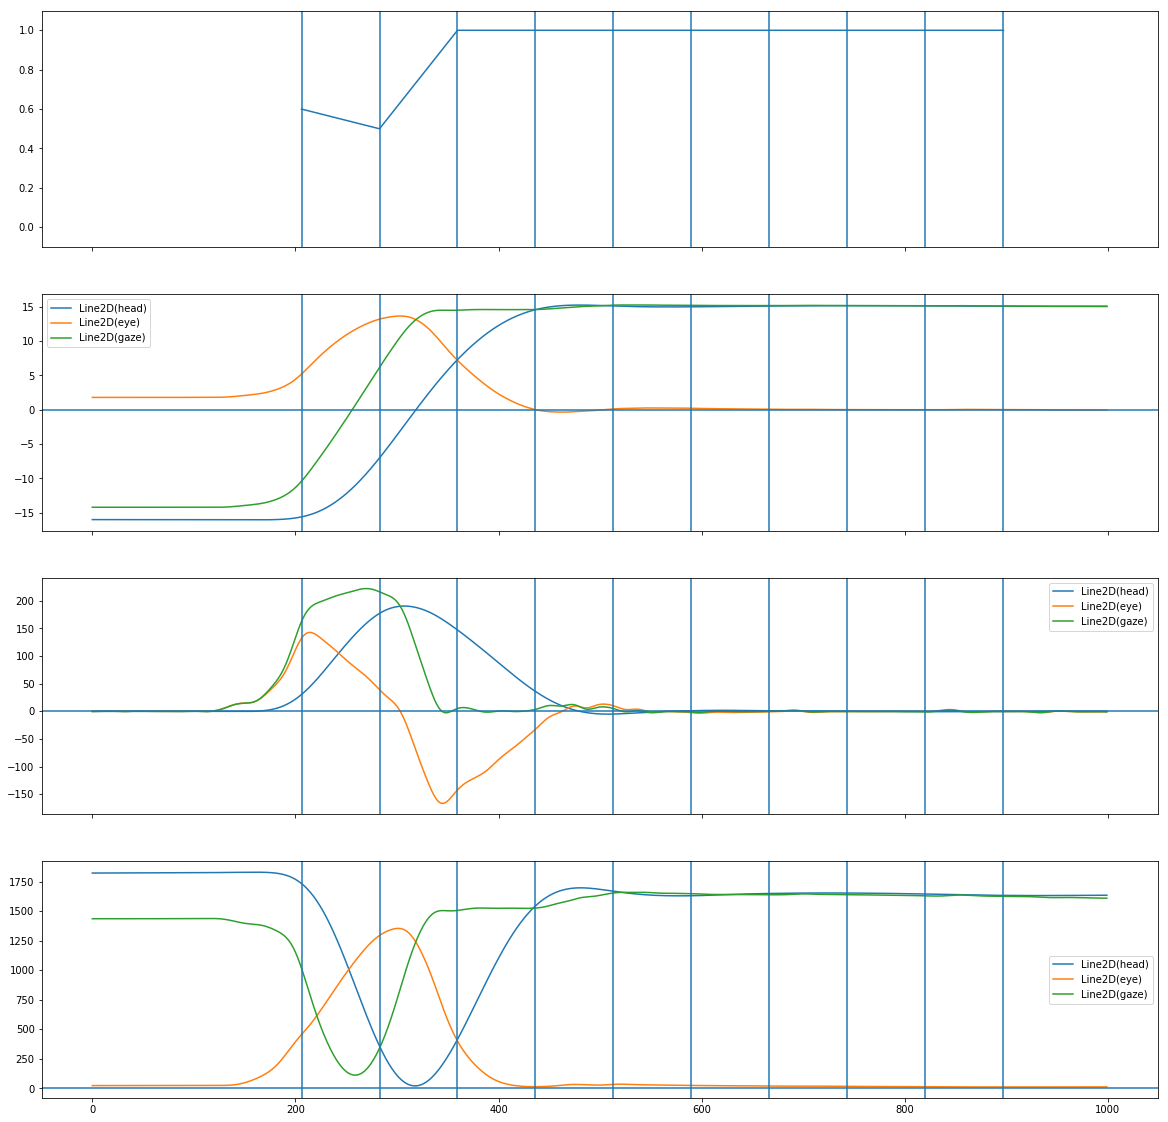

LeftDynamicAcuity


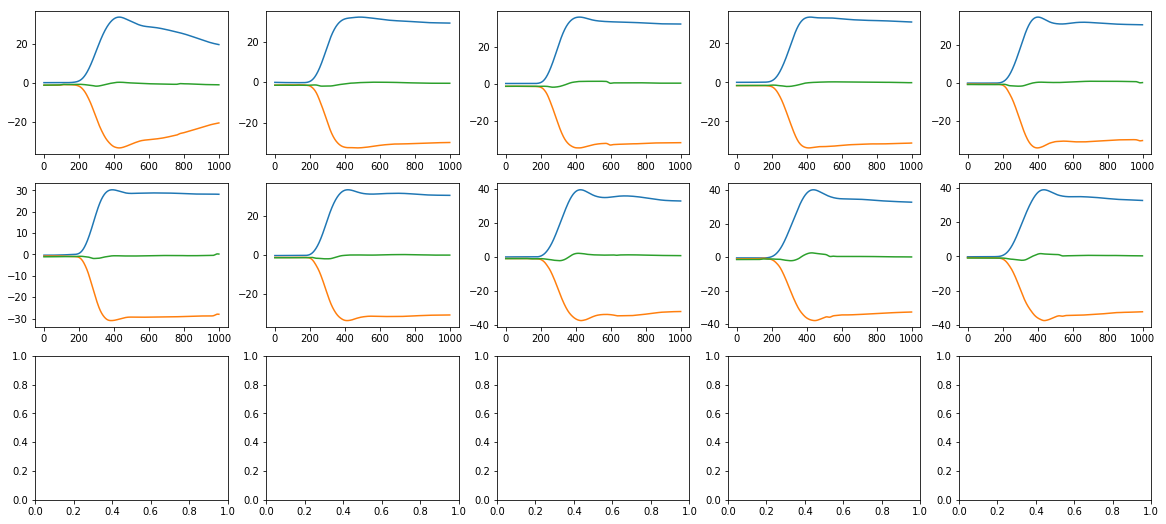

RightDynamicAcuity


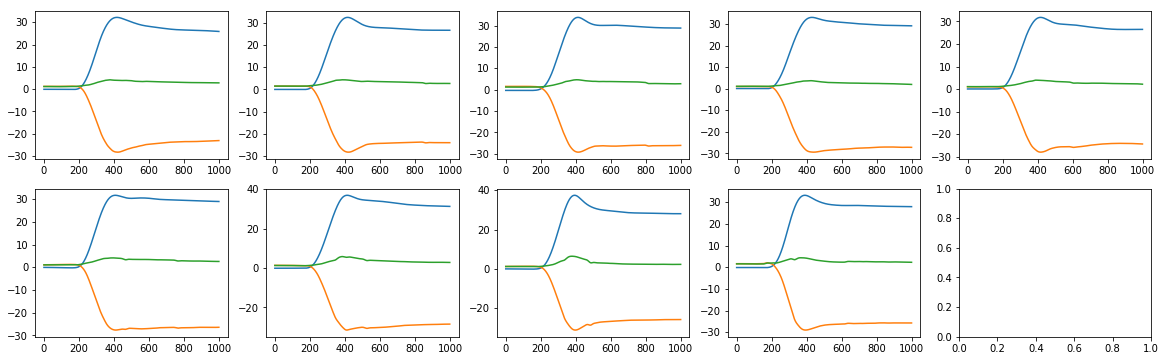

LeftGazeShift


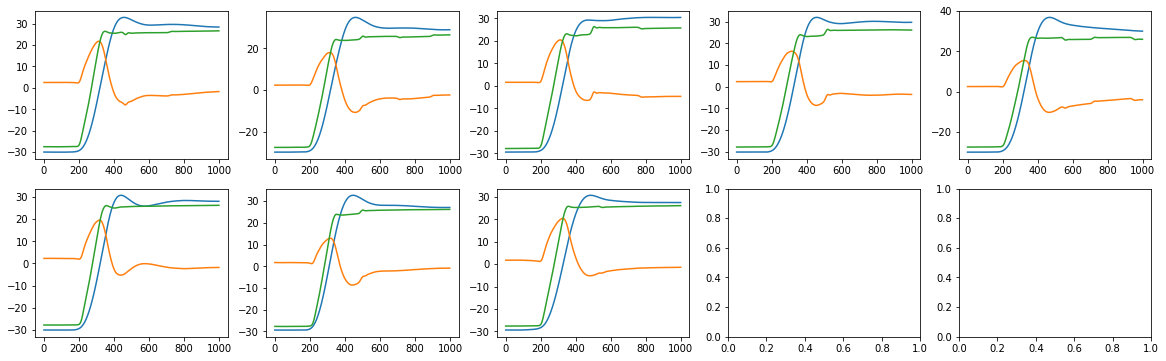

RightGazeShift


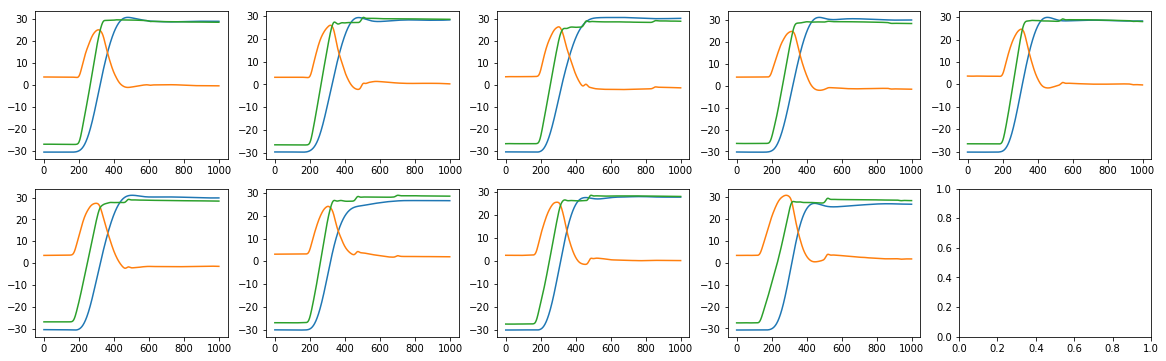

In [29]:
S_index += 1
sub_para = ["AcuityLog_2019_08_30_02_09_54.txt",\
        "AcuityLog_2019_08_30_02_25_56.txt",\
        "JumpLog__2019_08_30_02_09_54.txt",\
        "JumpLog__2019_08_30_02_25_56.txt",\
        "JumpLog__2019_08_30_02_25_56_2.txt",\
        "AcuityLog_2019_08_30_02_48_29.txt",\
        "",\
        "MIdata.mat",\
        "0",\
        "MIdataH.mat"
       ]
DY_DL = [0]
GA_DL = [0,7,17]
run_subject(sub_para, DY_DL = DY_DL, GA_DL = GA_DL, plot_detail = False)

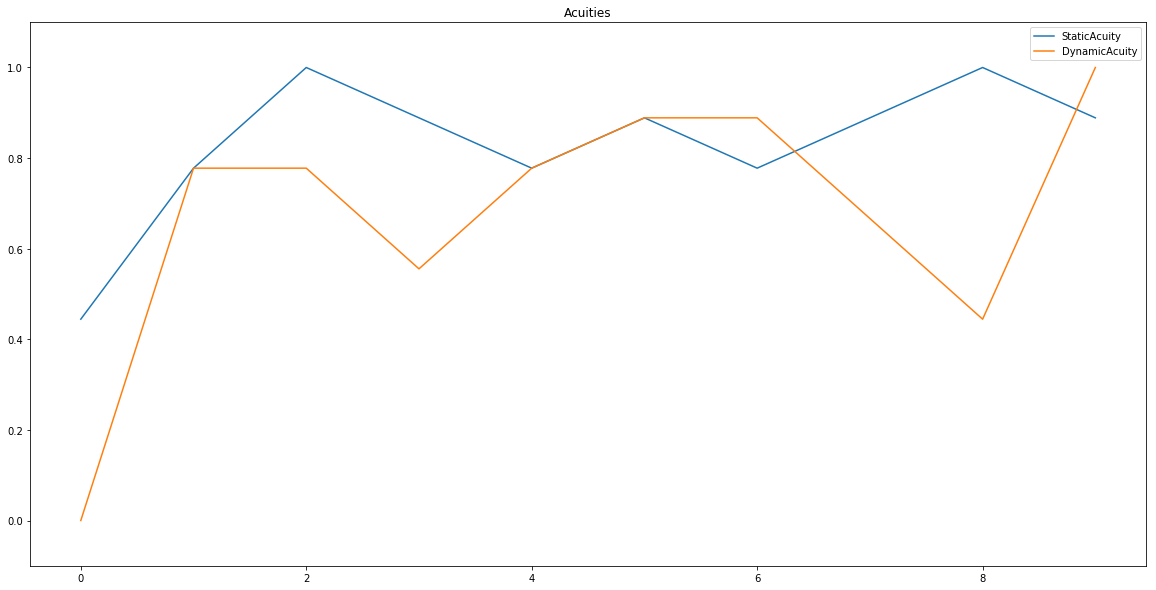

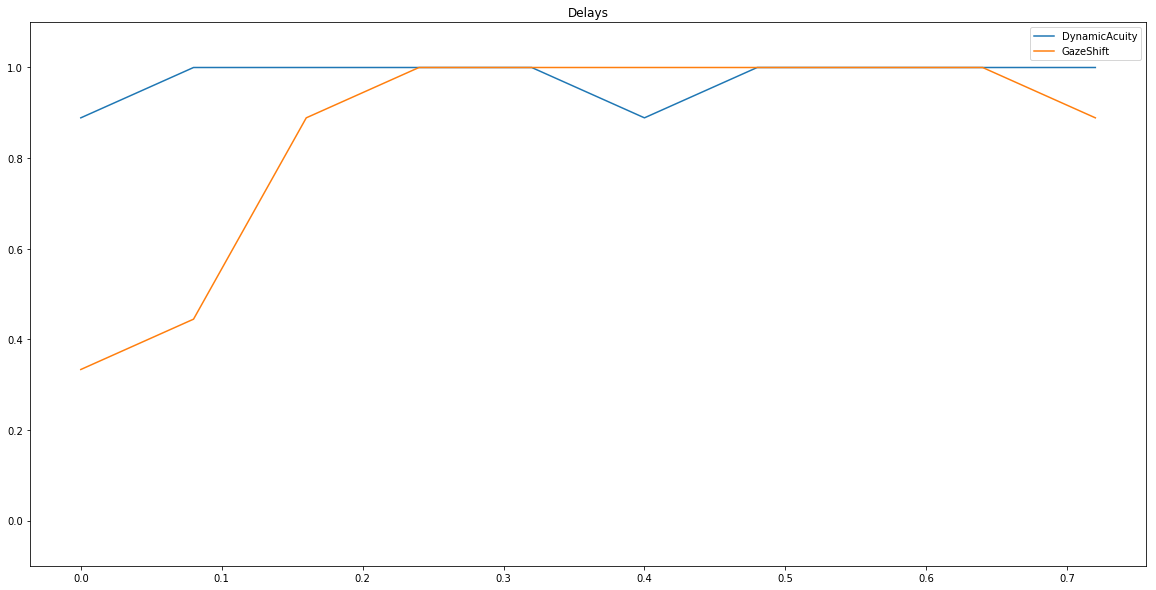

Left {0.0: [4, 5], 0.08: [4, 4], 0.16: [6, 6], 0.24: [5, 5], 0.32: [6, 6], 0.4: [6, 7], 0.48: [3, 3], 0.56: [3, 3], 0.64: [7, 7], 0.72: [4, 4]}
Right {0.0: [4, 4], 0.08: [5, 5], 0.16: [3, 3], 0.24: [4, 4], 0.32: [3, 3], 0.4: [2, 2], 0.48: [6, 6], 0.56: [6, 6], 0.64: [2, 2], 0.72: [5, 5]}


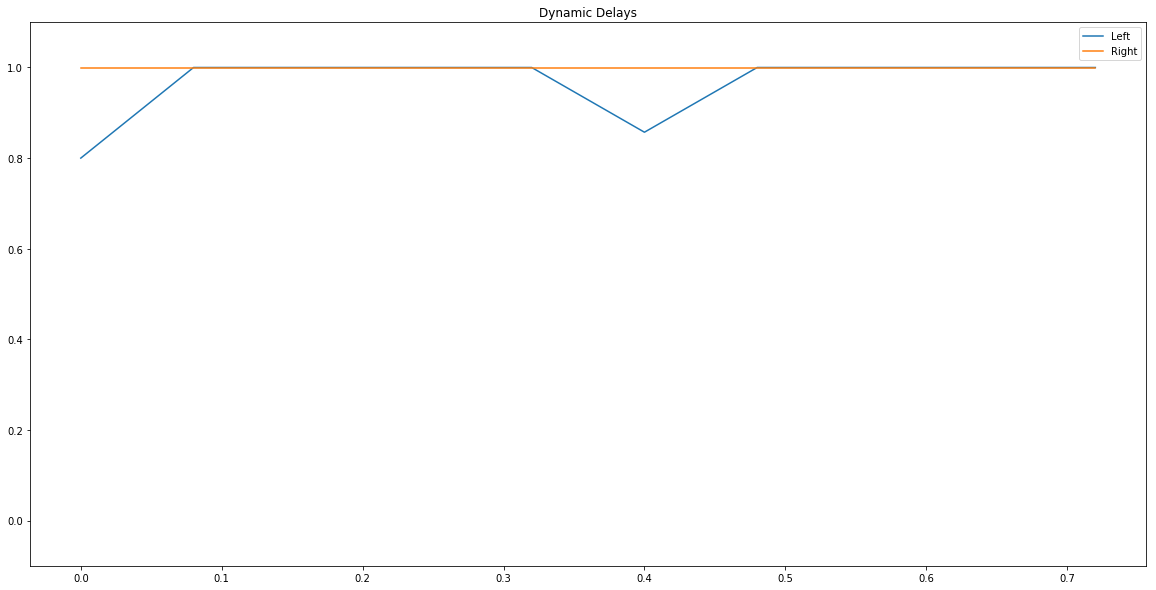

Left {0.0: [2, 4], 0.08: [2, 5], 0.16: [4, 4], 0.24: [5, 5], 0.32: [3, 3], 0.4: [5, 5], 0.48: [4, 4], 0.56: [5, 5], 0.64: [4, 4], 0.72: [4, 5]}
Right {0.0: [1, 4], 0.08: [2, 4], 0.16: [4, 5], 0.24: [4, 4], 0.32: [6, 6], 0.4: [4, 4], 0.48: [5, 5], 0.56: [4, 4], 0.64: [5, 5], 0.72: [4, 4]}


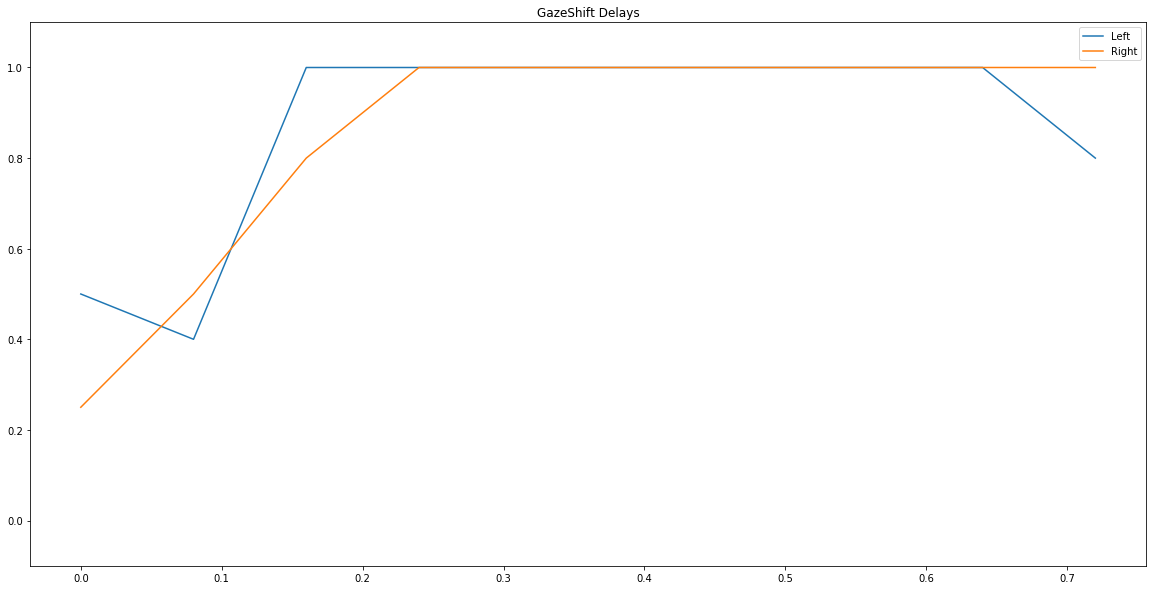

DynamicMeanPlot


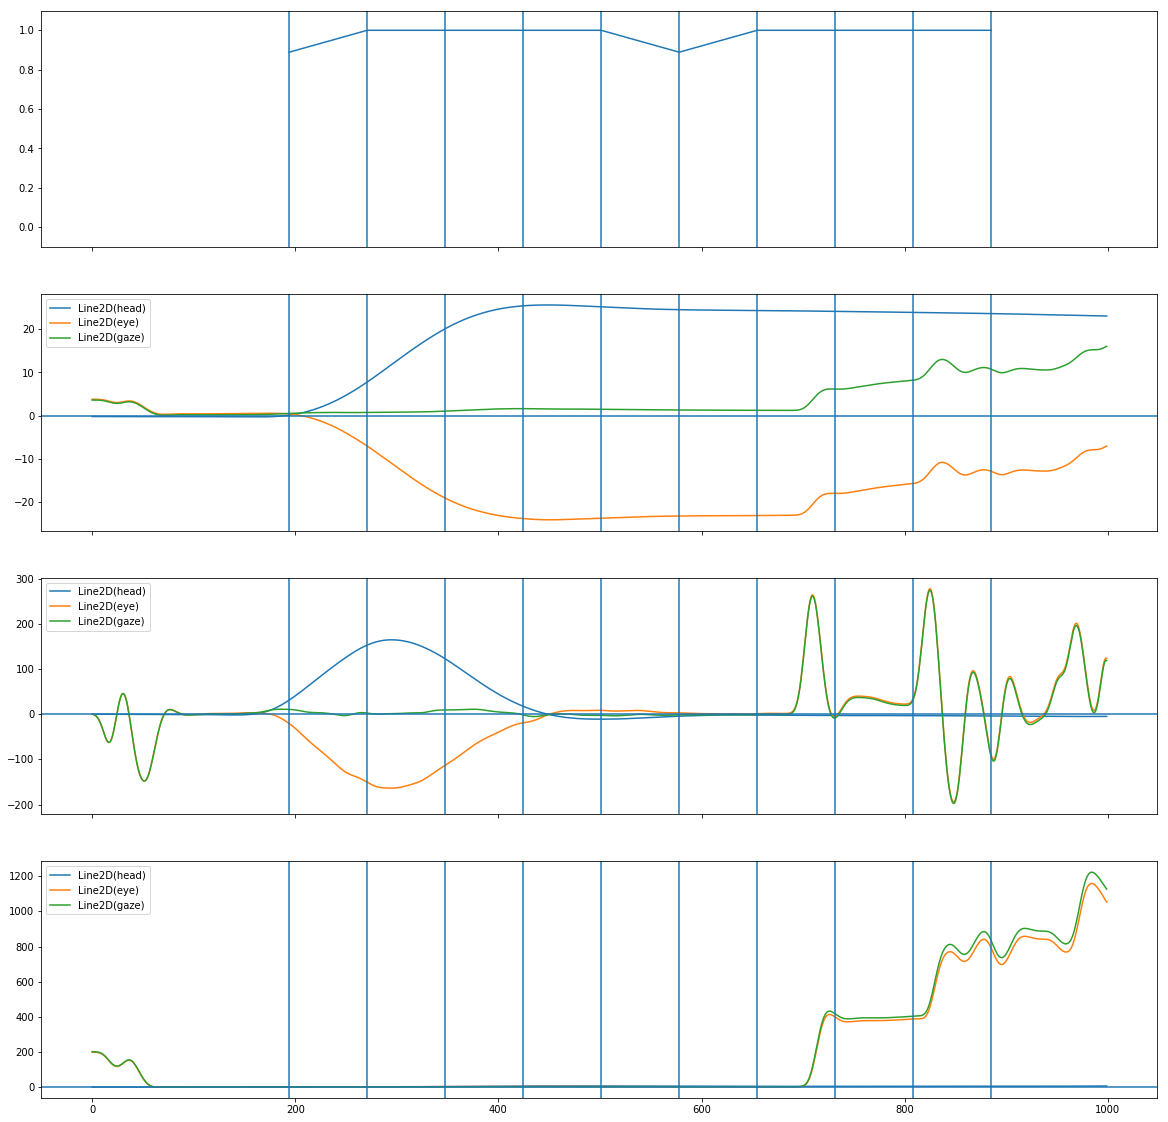

LeftDynamicMeanPlot


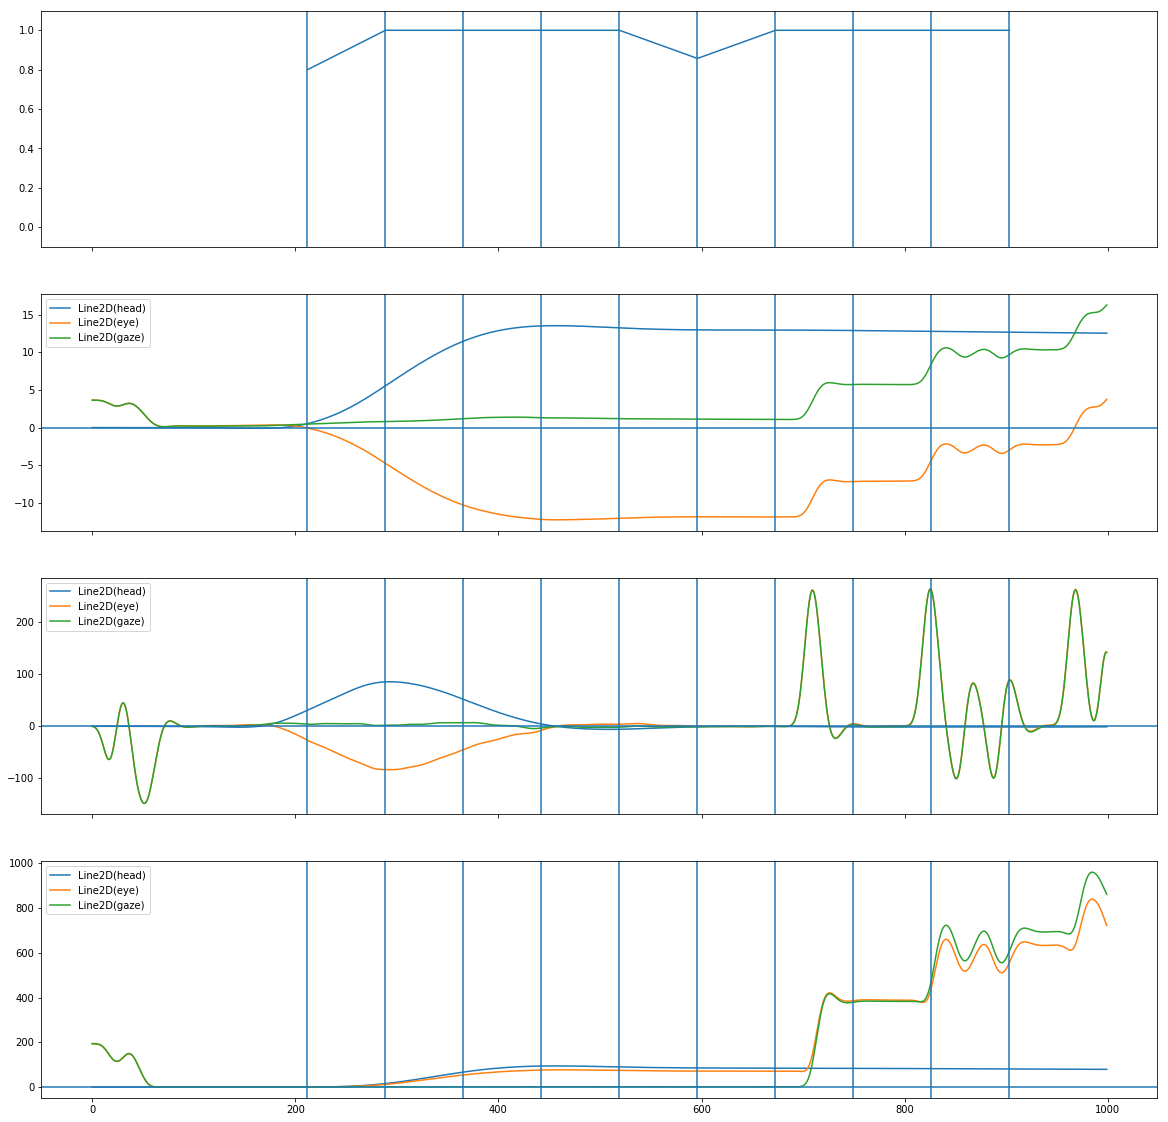

RightDynamicMeanPlot


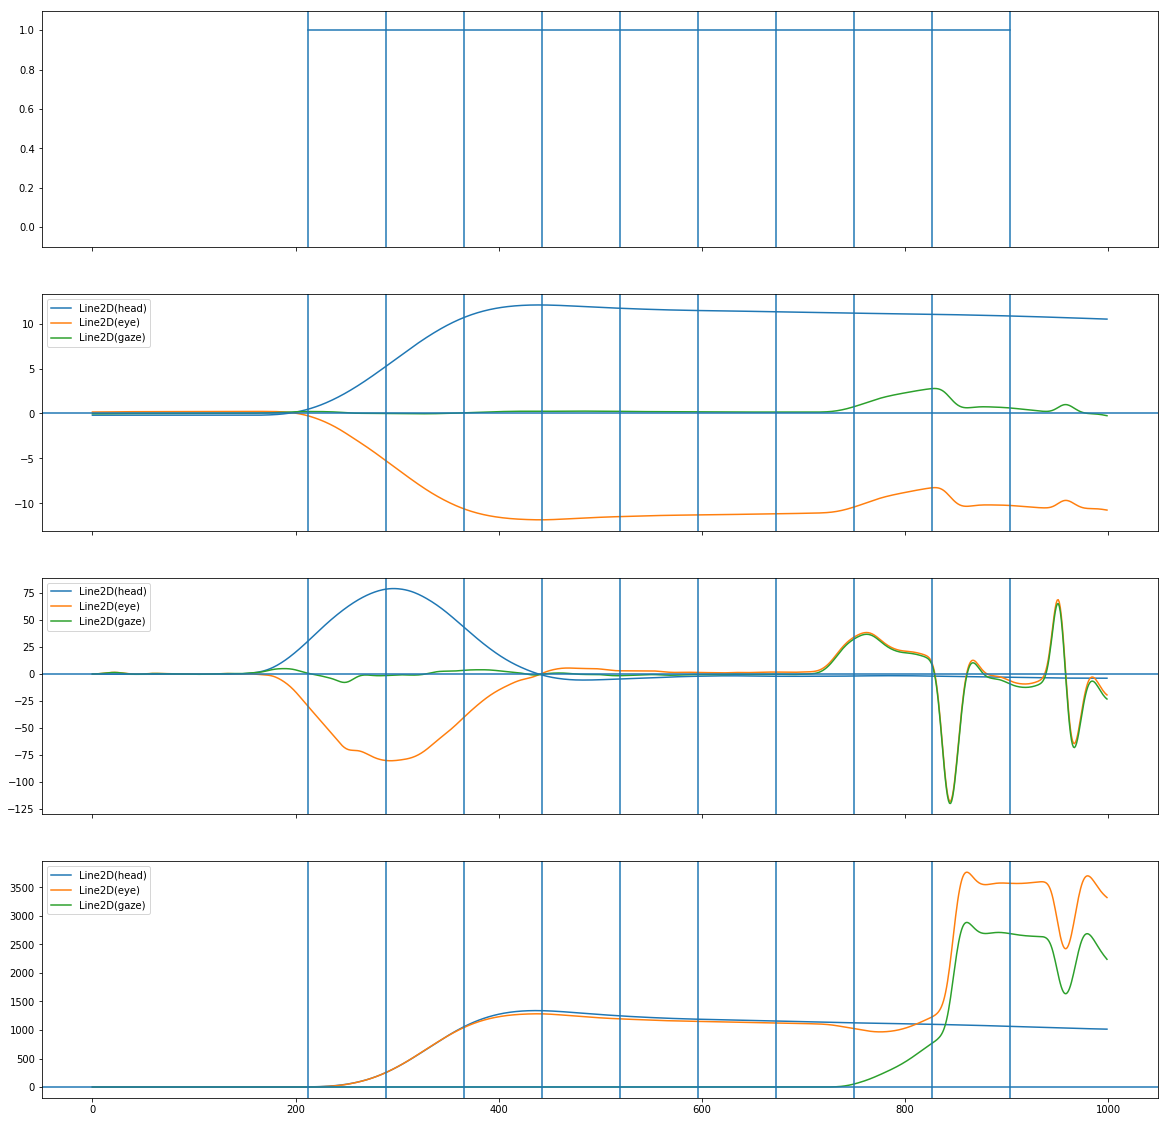

GazeShiftMeanPlot


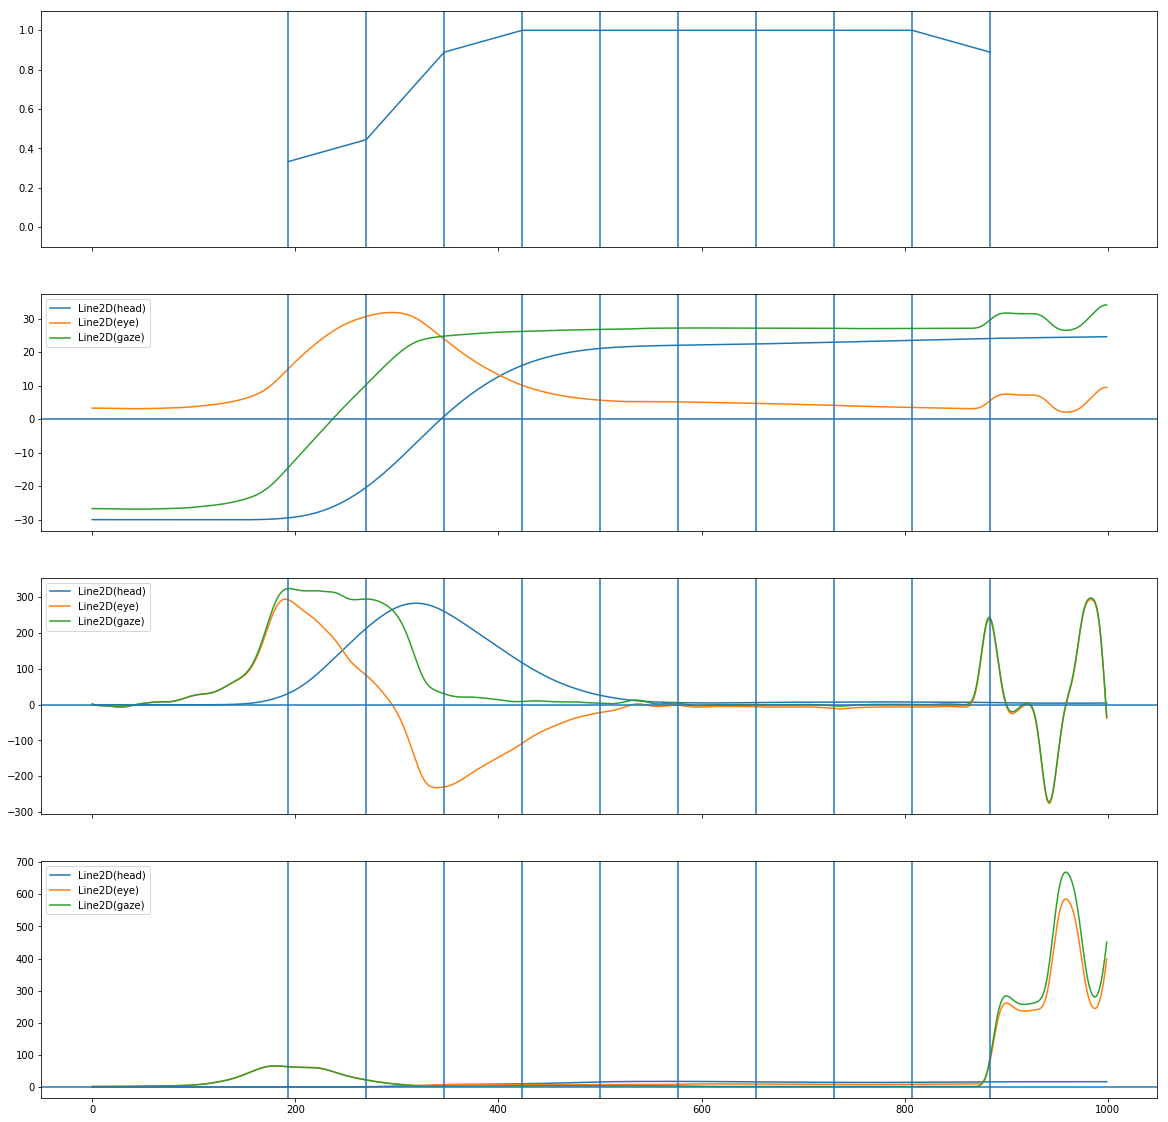

LeftGazeShiftMeanPlot


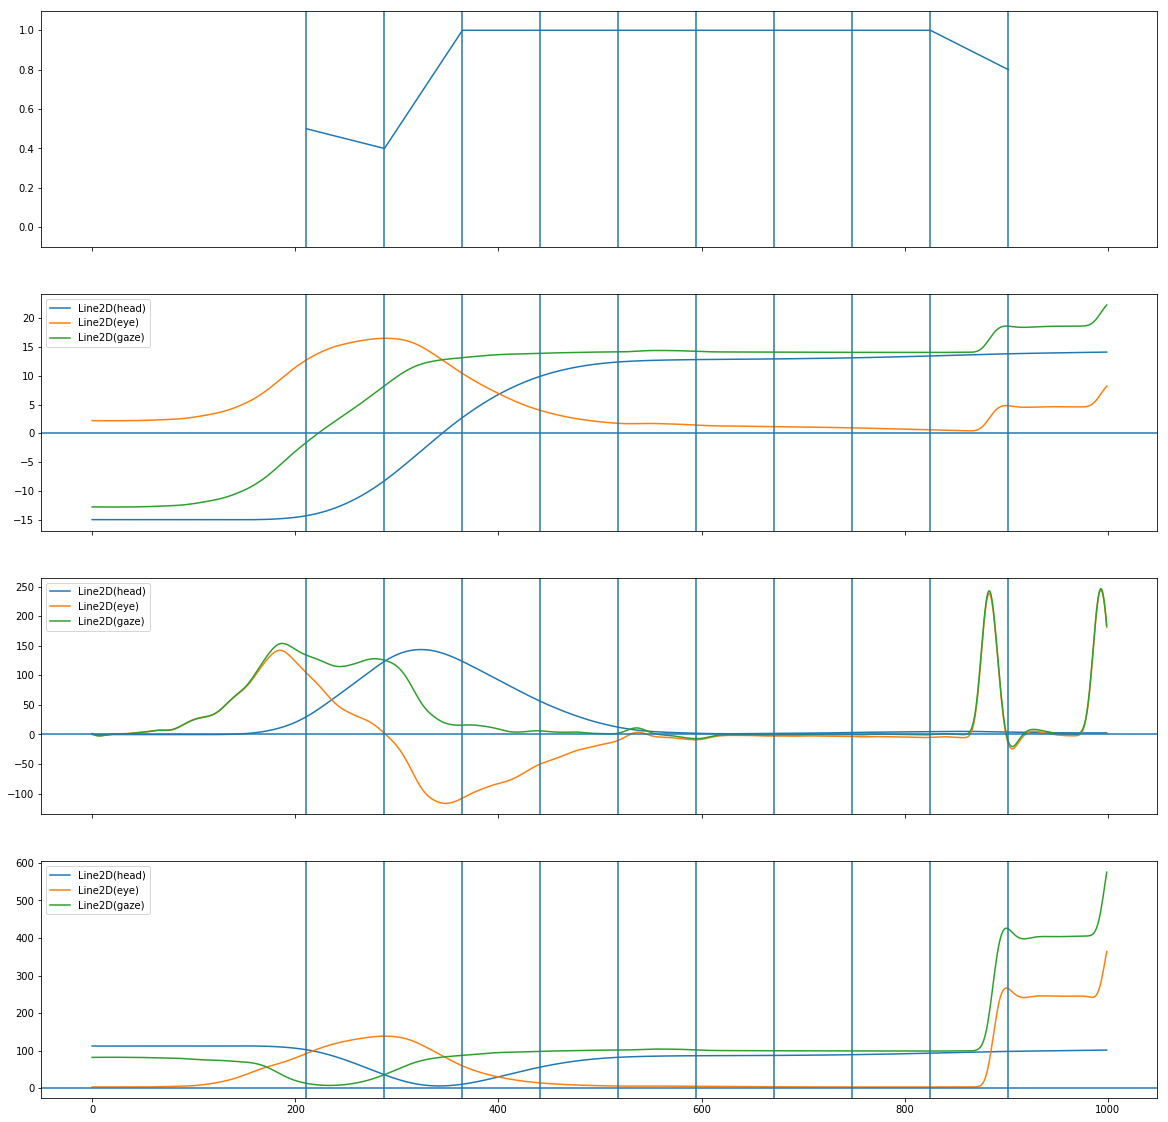

RightGazeShiftMeanPlot


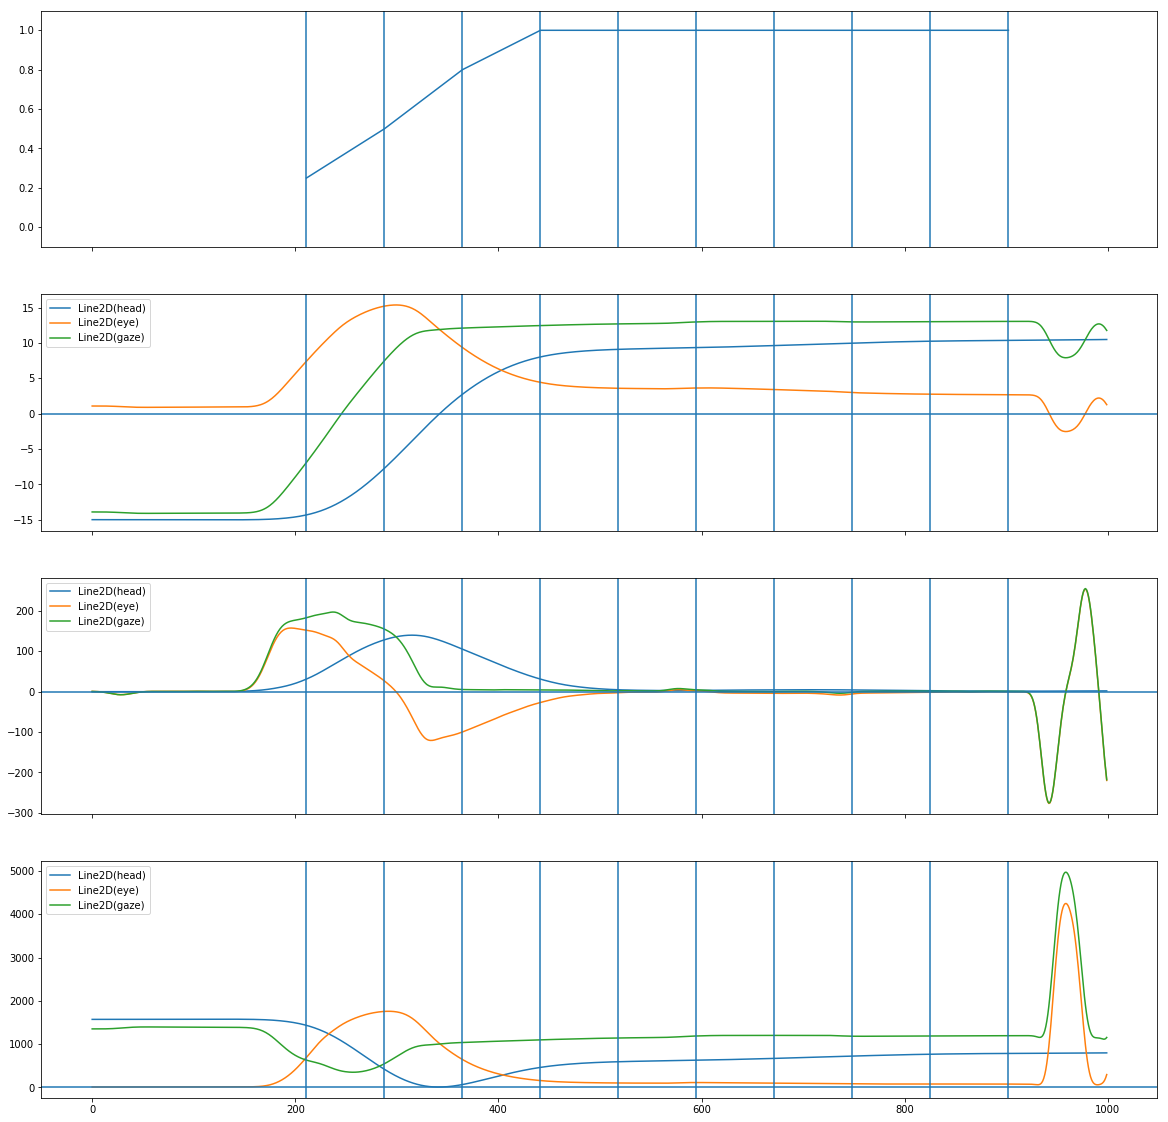

LeftDynamicAcuity


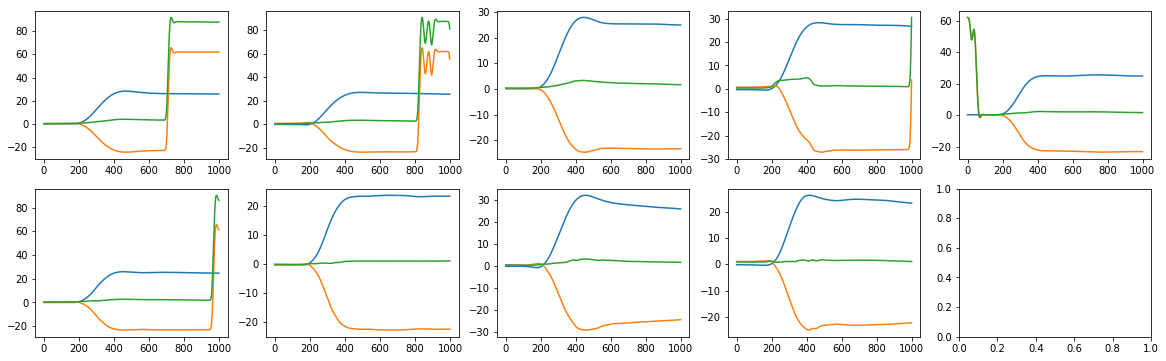

RightDynamicAcuity


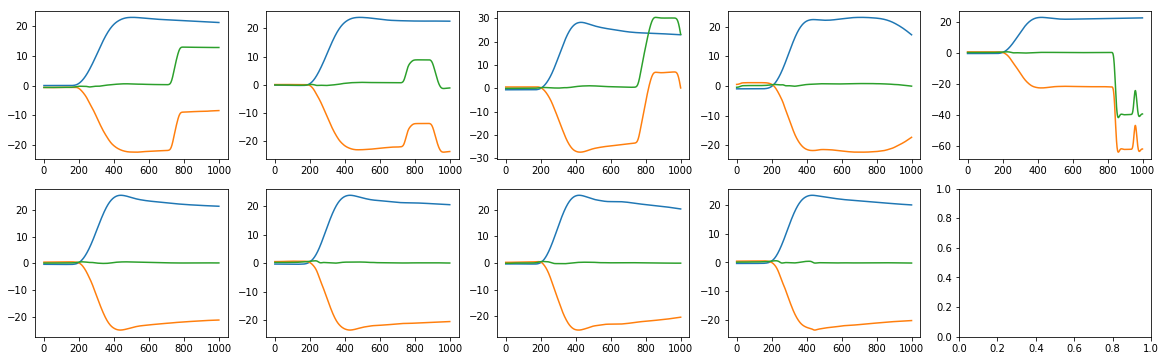

LeftGazeShift


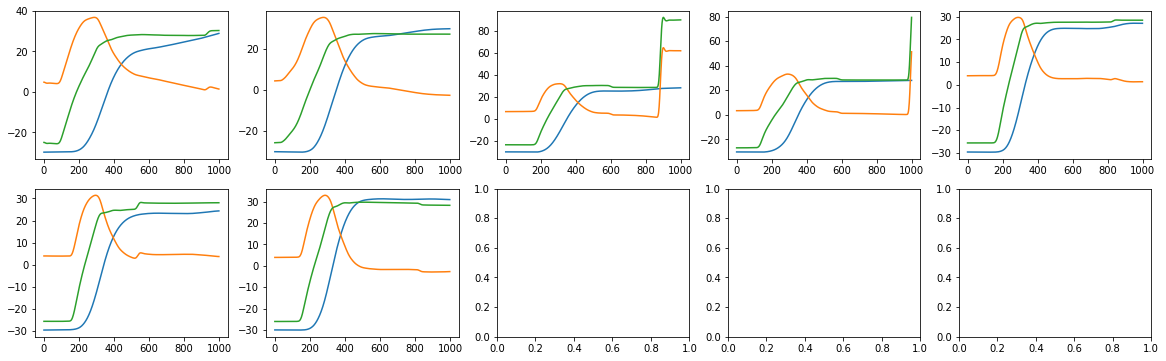

RightGazeShift


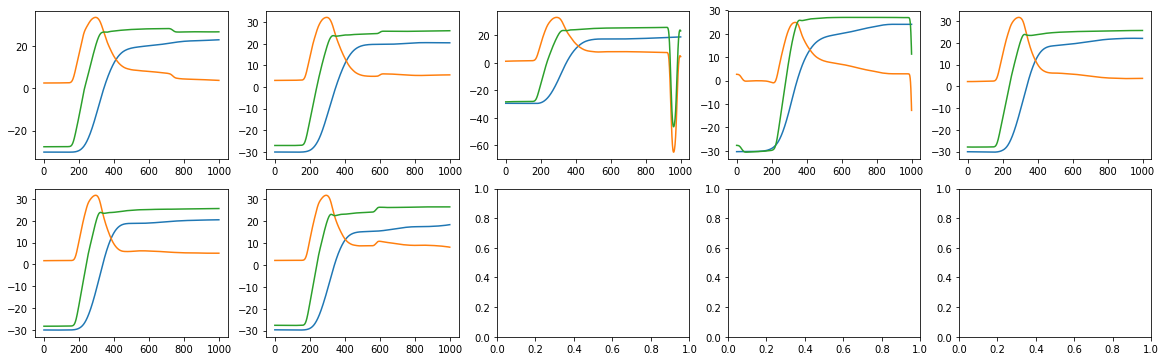

In [30]:
S_index += 1
sub_para = ["AcuityLog_2019_08_30_03_30_50.txt",\
            "AcuityLog_2019_08_30_03_55_04.txt",\
            "JumpLog__2019_08_30_03_30_50.txt",\
            "JumpLog__2019_08_30_03_55_04.txt",\
            "JumpLog__2019_08_30_03_55_04_2.txt",\
            "AcuityLog_2019_08_30_04_11_56.txt",\
            "",\
            "S1data.mat",\
            "1",\
            "S1dataH.mat"]
DY_DL = [7,10]
GA_DL = [0,7,8,9,10,11]
run_subject(sub_para, DY_DL = DY_DL, GA_DL = GA_DL, plot_detail = False)

In [34]:
S_index += 1
sub_para = ["AcuityLog_2019_09_18_05_23_42.txt",\
            "AcuityLog_2019_09_18_05_36_44.txt",\
            "JumpLog__2019_09_18_05_23_42.txt",\
            "JumpLog__2019_09_18_05_36_44.txt",\
            "JumpLog__2019_09_18_05_36_44_2.txt",\
            "AcuityLog_2019_09_18_05_53_13.txt",\
            "",\
            "",\
            "1",\
            ""]
DY_DL = []
GA_DL = []
run_subject(sub_para, DY_DL = DY_DL, GA_DL = GA_DL, plot_detail = False)

IndexError: list index out of range

In [31]:
#Plots for all subjects
def mix_plot():
    handles = []
    for SS in StaticSections:
        tpl = plot_ac(SS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"StaticMix"+".png")
    pyplot.title("Static Acuity")
    pyplot.show()
    
    handles = []
    for DS in DynamicSections:
        tpl = plot_ac(DS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"DynamicMix"+".png")
    pyplot.title("Dynamic Acuity")
    pyplot.show()
    
    handles = []
    for DDS in DY_delaySections:
        tpl = plot_delay(DDS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"DynamicDelayMix"+".png")
    pyplot.title("Dynamic Delay")
    pyplot.show()
    
    handles = []
    for GDS in GA_delaySections:
        tpl = plot_delay(GDS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"GazeDelayMix"+".png")
    pyplot.title("Gazeshift Delay")
    pyplot.show()

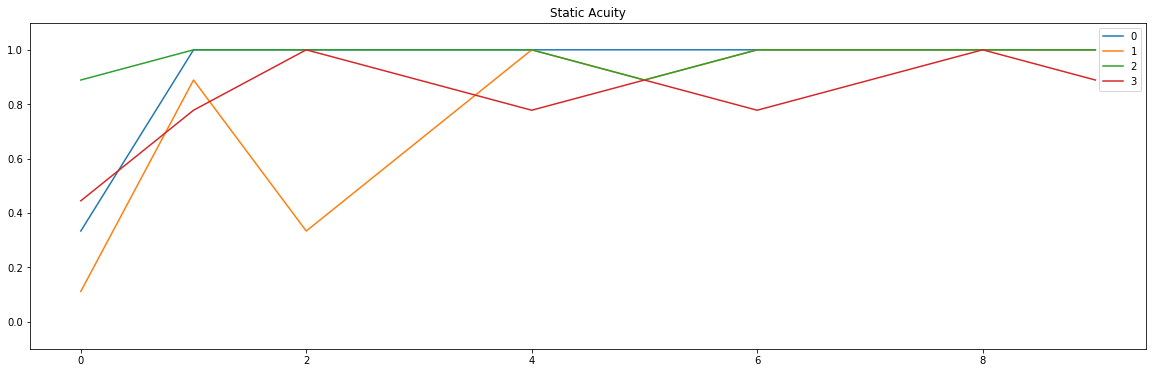

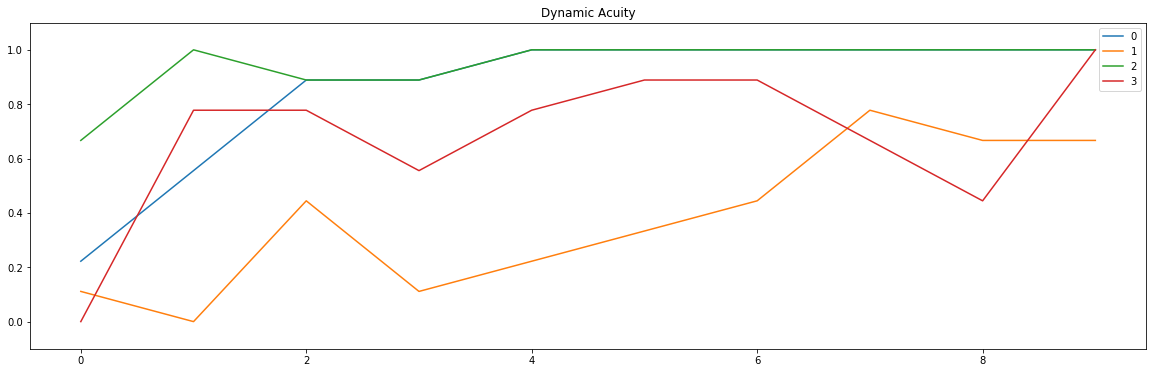

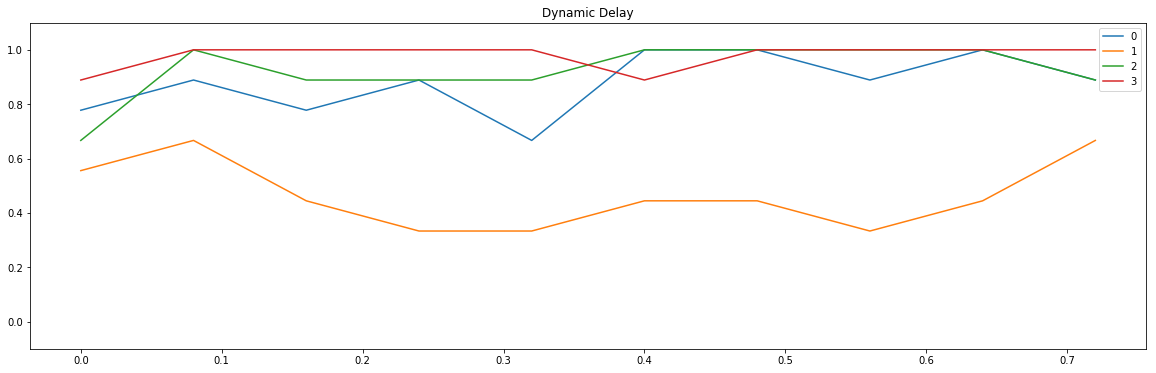

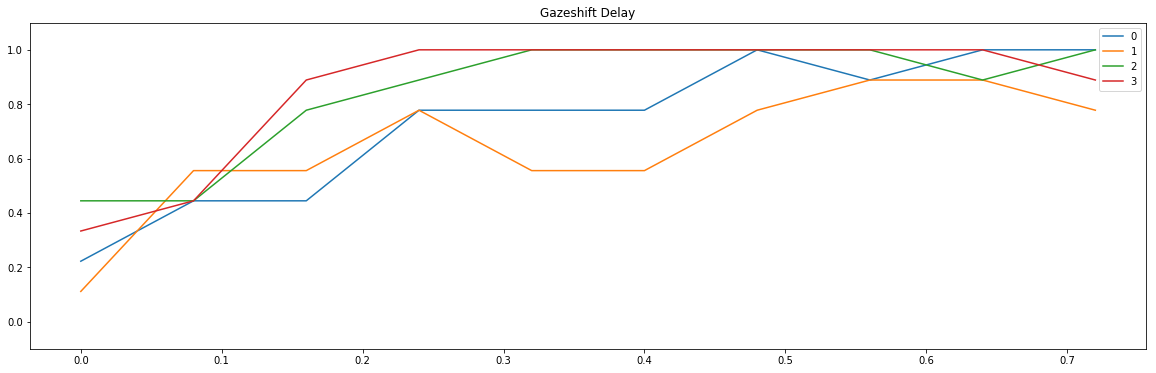

In [32]:
mix_plot()